# **Pruebas ML IoTD20**

In [1]:
def find_columns_with_missing_values(df):
    """
    Find columns in the DataFrame that have missing values, such as NaNs, empty strings, or "-".

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    list: A list of column names that contain missing values.
    """
    missing_value_columns = []

    # Iterate through each column in the DataFrame
    for column in df.columns:
        # Check for NaNs, empty strings, or "-"
        if df[column].isna().any() or (df[column] == "").any() or (df[column] == "-").any() or (df[column] == "[]").any():
            missing_value_columns.append(column)
    print(df.columns)
    return missing_value_columns

def check_missing_value_types(df, columns):
    """
    Check for the types of missing values in the specified columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.
    columns (list): The list of column names to check for missing values.

    Returns:
    dict: A dictionary where keys are column names and values are sets of missing value types.
    """
    missing_value_types = {}

    for column in columns:
        types = set()
        
        if df[column].isna().any():
            types.add("NaN")
        
        if (df[column] == "").any():
            types.add('""')
        
        if (df[column] == "-").any():
            types.add('"-"')
        
        missing_value_types[column] = types
    
    return missing_value_types

def replace_missing_values(df, column_names, nan_value=None, empty_value=None, placeholder_value=None):
    """
    Replace missing values in specified columns of the DataFrame with different values for NaNs, empty strings, and placeholders.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns.
    column_names (str or list): The name(s) of the columns to replace values in.
    nan_value: The value to replace NaNs with.
    empty_value: The value to replace empty strings with.
    placeholder_value: The value to replace specific placeholder values with.

    Returns:
    pd.DataFrame: The DataFrame with the replaced values.
    """
    if isinstance(column_names, str):
        column_names = [column_names]

    for column_name in column_names:
        if column_name in df.columns:
            if nan_value is not None:
                df[column_name] = df[column_name].fillna(nan_value)
            if empty_value is not None:
                df[column_name] = df[column_name].replace("", empty_value)
            if placeholder_value is not None:
                df[column_name] = df[column_name].replace("-", placeholder_value)
        else:
            print(f"Column '{column_name}' does not exist in the DataFrame.")

    return df

In [2]:
from dask.distributed import Client
import joblib
# Initialize Dask client
client = Client(n_workers=15)


2024-06-18 07:25:05,357 - distributed.nanny - WARNING - Restarting worker
2024-06-18 07:25:05,414 - distributed.nanny - WARNING - Restarting worker
2024-06-18 07:25:05,512 - distributed.nanny - WARNING - Restarting worker
2024-06-18 07:25:05,824 - distributed.nanny - WARNING - Restarting worker
2024-06-18 07:25:06,842 - distributed.nanny - WARNING - Restarting worker


## **Preprocesado**

In [3]:
import pandas as pd
import numpy as np

In [4]:
df_iotd20 = pd.read_csv("/root/bbdd/logs-zeek/iotd20-logs/all-labeled-final_v2.csv")

/tmp/ipykernel_4409/1819021055.py:1: DtypeWarning: Columns (9,10,11,13,14,24,42,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iotd20 = pd.read_csv("/root/bbdd/logs-zeek/iotd20-logs/all-labeled-final_v2.csv")


In [5]:
df_iotd20.head()

ts            startTime                 uid  \
0  1.559706e+09  2019-06-05 03:43:27  CCVKbi1oFUm00QR70j   
1  1.559706e+09  2019-06-05 03:43:27  C5WTOe2BhBVzdrKyu2   
2  1.559706e+09  2019-06-05 03:43:30  CRzHSO1XahGLA24eUe   
3  1.559706e+09  2019-06-05 03:43:35  CkjYIu19Om8rrb1mP1   
4  1.559706e+09  2019-06-05 03:43:38  CQVPAK2JE7kAgKDZGc   

                   id.orig_h  id.orig_p    id.resp_h  id.resp_p proto service  \
0               192.168.0.14       5353  224.0.0.251       5353   udp     dns   
1  fe80::10cc:207d:e8e8:1062       5353     ff02::fb       5353   udp     dns   
2               192.168.0.23      17819  163.152.1.1         53   udp     dns   
3               192.168.0.23       5019  163.152.1.1         53   udp     dns   
4               192.168.0.23      48407  163.152.1.1         53   udp     dns   

   duration  ... orig_time_min orig_time_max resp_time_mean resp_time_min  \
0  0.228234  ...      0.000451      0.110581            0.0       10000.0   
1  0.227962  ...      0.000408      0.110620            0.0       10000.0   
2  0.002155  ...      0.002155      0.002155            0.0       10000.0   
3  0.001585  ...      0.001585      0.001585            0.0       10000.0   
4  0.001435  ...      0.001435      0.001435            0.0       10000.0   

  resp_time_max  resp_bytes_std resp_time_std  binary-label   label  \
0           0.0             NaN           NaN             0  benign   
1           0.0             NaN           NaN             0  benign   
2           0.0             0.0           NaN             0  benign   
3           0.0             0.0           NaN             0  benign   
4           0.0             0.0           NaN             0  benign   

   detailed-label  
0          benign  
1          benign  
2          benign  
3          benign  
4          benign  

[5 rows x 53 columns]

In [6]:
# Find columns with missing values
missing_value_columns = find_columns_with_missing_values(df_iotd20)
print("Columns with missing values:", missing_value_columns)

# Check types of missing values in these columns
missing_value_types = check_missing_value_types(df_iotd20, missing_value_columns)
for column, types in missing_value_types.items():
    print(f"Column '{column}' has the following types of missing values: {types}")

Index(['ts', 'startTime', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h',
       'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'orig_bytes_mean', 'resp_bytes_mean',
       'orig_bytes_std', 'orig_bytes_mean_nocero', 'resp_bytes_mean_nocero',
       'orig_bytes_std_nocero', 'resp_bytes_std_nocero', 'orig_bytes_min',
       'resp_bytes_min', 'orig_bytes_max', 'resp_bytes_max',
       'orig_pkts_nocero', 'resp_pkts_nocero', 'orig_pkts_cero',
       'resp_pkts_cero', 'time_mean', 'time_std', 'time_min', 'time_max',
       'orig_time_mean', 'orig_time_std', 'orig_time_min', 'orig_time_max',
       'resp_time_mean', 'resp_time_min', 'resp_time_max', 'resp_bytes_std',
       'resp_time_std', 'binary-label', 'label', 'detailed-label'],
      dtype='object')
Columns with missing values: ['service', 'durat

In [7]:
df_iotd20 = replace_missing_values(df_iotd20, column_names=['duration', 'orig_bytes', 'resp_bytes', 'tunnel_parents', 'orig_bytes_std', 'orig_time_std', 'resp_bytes_std', 'resp_time_std'], nan_value=0,placeholder_value=0)
df_iotd20 = replace_missing_values(df_iotd20, column_names='history', nan_value="-")
df_iotd20 = replace_missing_values(df_iotd20, column_names='conn_state', nan_value="-")
df_iotd20 = replace_missing_values(df_iotd20, column_names='service', nan_value="unknown",placeholder_value="unknown")

print(df_iotd20)

                  ts            startTime                 uid  \
0       1.559706e+09  2019-06-05 03:43:27  CCVKbi1oFUm00QR70j   
1       1.559706e+09  2019-06-05 03:43:27  C5WTOe2BhBVzdrKyu2   
2       1.559706e+09  2019-06-05 03:43:30  CRzHSO1XahGLA24eUe   
3       1.559706e+09  2019-06-05 03:43:35  CkjYIu19Om8rrb1mP1   
4       1.559706e+09  2019-06-05 03:43:38  CQVPAK2JE7kAgKDZGc   
...              ...                  ...                 ...   
129352  1.558343e+09  2019-05-20 08:59:42  CjsZ3Y23h1jf7Nf9X2   
129353  1.558343e+09  2019-05-20 08:56:20  Cc8zB51RLGBaxCOCJk   
129354  1.558343e+09  2019-05-20 08:56:51  CweQUr3DBGJlToZpM6   
129355  1.558343e+09  2019-05-20 09:00:19  CCKLtU1PDO9HqVTM53   
129356  1.558343e+09  2019-05-20 08:56:23  C52ghL3hDnn9mlTQDi   

                        id.orig_h  id.orig_p       id.resp_h  id.resp_p proto  \
0                    192.168.0.14       5353     224.0.0.251       5353   udp   
1       fe80::10cc:207d:e8e8:1062       5353        ff02:

In [8]:
# Find columns with missing values
missing_value_columns = find_columns_with_missing_values(df_iotd20)
print("Columns with missing values:", missing_value_columns)

# Check types of missing values in these columns
missing_value_types = check_missing_value_types(df_iotd20, missing_value_columns)
for column, types in missing_value_types.items():
    print(f"Column '{column}' has the following types of missing values: {types}")

Index(['ts', 'startTime', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h',
       'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'orig_bytes_mean', 'resp_bytes_mean',
       'orig_bytes_std', 'orig_bytes_mean_nocero', 'resp_bytes_mean_nocero',
       'orig_bytes_std_nocero', 'resp_bytes_std_nocero', 'orig_bytes_min',
       'resp_bytes_min', 'orig_bytes_max', 'resp_bytes_max',
       'orig_pkts_nocero', 'resp_pkts_nocero', 'orig_pkts_cero',
       'resp_pkts_cero', 'time_mean', 'time_std', 'time_min', 'time_max',
       'orig_time_mean', 'orig_time_std', 'orig_time_min', 'orig_time_max',
       'resp_time_mean', 'resp_time_min', 'resp_time_max', 'resp_bytes_std',
       'resp_time_std', 'binary-label', 'label', 'detailed-label'],
      dtype='object')
Columns with missing values: ['history', 'tunne

Codificar

In [9]:
import sklearn
from sklearn.preprocessing import LabelEncoder

In [10]:
label_encoder_proto = LabelEncoder()
label_encoder_service = LabelEncoder()
label_encoder_history = LabelEncoder()
label_encoder_conn_state = LabelEncoder()
label_encoder_local_orig = LabelEncoder()
label_encoder_local_resp = LabelEncoder()

In [11]:
# Check the types of values in the 'local_orig' column
print(df_iotd20['local_resp'].apply(type).value_counts())

# Print unique values in 'local_orig'
print(df_iotd20['local_resp'].unique())

local_resp
<class 'bool'>    114688
<class 'str'>      14669
Name: count, dtype: int64
[False True 'True' 'False' 'T' 'F']


In [12]:
# Normalize 'local_orig' column values
def normalize_local(value):
    if value in [True, 'True', 'T']:
        return 'True'
    elif value in [False, 'False', 'F']:
        return 'False'
    else:
        return value

df_iotd20['local_orig'] = df_iotd20['local_orig'].apply(normalize_local)
df_iotd20['local_resp'] = df_iotd20['local_resp'].apply(normalize_local)

In [13]:
df_iotd20['proto'] = label_encoder_proto.fit_transform(df_iotd20['proto'])
df_iotd20['service'] = label_encoder_service.fit_transform(df_iotd20['service'])
df_iotd20['history'] = label_encoder_history.fit_transform(df_iotd20['history'])
df_iotd20['conn_state'] = label_encoder_conn_state.fit_transform(df_iotd20['conn_state'])
df_iotd20['local_orig'] = label_encoder_local_orig.fit_transform(df_iotd20['local_orig'])
df_iotd20['local_resp'] = label_encoder_local_resp.fit_transform(df_iotd20['local_resp'])

In [14]:
# Verify the transformation
df_iotd20.head()

ts            startTime                 uid  \
0  1.559706e+09  2019-06-05 03:43:27  CCVKbi1oFUm00QR70j   
1  1.559706e+09  2019-06-05 03:43:27  C5WTOe2BhBVzdrKyu2   
2  1.559706e+09  2019-06-05 03:43:30  CRzHSO1XahGLA24eUe   
3  1.559706e+09  2019-06-05 03:43:35  CkjYIu19Om8rrb1mP1   
4  1.559706e+09  2019-06-05 03:43:38  CQVPAK2JE7kAgKDZGc   

                   id.orig_h  id.orig_p    id.resp_h  id.resp_p  proto  \
0               192.168.0.14       5353  224.0.0.251       5353      2   
1  fe80::10cc:207d:e8e8:1062       5353     ff02::fb       5353      2   
2               192.168.0.23      17819  163.152.1.1         53      2   
3               192.168.0.23       5019  163.152.1.1         53      2   
4               192.168.0.23      48407  163.152.1.1         53      2   

   service  duration  ... orig_time_min orig_time_max  resp_time_mean  \
0        1  0.228234  ...      0.000451      0.110581             0.0   
1        1  0.227962  ...      0.000408      0.110620             0.0   
2        1  0.002155  ...      0.002155      0.002155             0.0   
3        1  0.001585  ...      0.001585      0.001585             0.0   
4        1  0.001435  ...      0.001435      0.001435             0.0   

   resp_time_min  resp_time_max  resp_bytes_std  resp_time_std  binary-label  \
0        10000.0            0.0               0              0             0   
1        10000.0            0.0               0              0             0   
2        10000.0            0.0             0.0              0             0   
3        10000.0            0.0             0.0              0             0   
4        10000.0            0.0             0.0              0             0   

    label  detailed-label  
0  benign          benign  
1  benign          benign  
2  benign          benign  
3  benign          benign  
4  benign          benign  

[5 rows x 53 columns]

In [15]:
# Update the labels based on conditions
df_iotd20.loc[(df_iotd20['label'] == "Mirai") & (df_iotd20['detailed-label'].str.contains('Telnet')), 'label'] = "BruteForce"
df_iotd20.loc[(df_iotd20['label'] == "Mirai") & (~df_iotd20['detailed-label'].str.contains('Telnet')), 'label'] = "DoS"

In [16]:
df_iotd20['label'].unique()

array(['benign', 'DoS', 'BruteForce', 'Scan'], dtype=object)

## **Training y test**

In [17]:
#!pip install fpdf

In [18]:
from fpdf import FPDF
from IPython.display import display, Markdown

In [19]:
# Create PDF with fpdf
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Classification Report with Metrics, Training, and Testing Time', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(10)

    def chapter_body(self, body):
        self.set_font('Arial', '', 10)
        self.multi_cell(0, 5, body)
        self.ln()

    def add_image(self, image_path, title=''):
        if title:
            self.chapter_title(title)
        self.image(image_path, x=10, y=None, w=180)
        self.ln(10)
        
    def add_classification_report(self, report):
        self.chapter_title("Classification Report:")
        self.chapter_body(report)

Al final de la línea hay comentados local_resp y local_orig, por si son demasiado relevantes, descomentarlos

In [20]:
x_iotd20 = df_iotd20.drop(columns=['ts','startTime','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','tunnel_parents','binary-label','label','detailed-label'])#,'local_orig','local_resp'])
y_binary = df_iotd20['binary-label']
y = df_iotd20['label']
y_detailed = df_iotd20['detailed-label']

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_iotd20, y, test_size=0.6, random_state=42)
x_train_orig, x_test_orig, y_train_orig, y_test_orig = x_train, x_test, y_train, y_test

In [22]:
print(x_train.shape)
print(x_test.shape)

(51742, 42)
(77615, 42)


In [23]:
x_train.head()

proto  service  duration orig_bytes resp_bytes  conn_state  \
77245       1        7  0.006626        0.0       24.0           5   
14709       1        7  0.007483        0.0        0.0           7   
3588        1        7  0.000658        0.0        0.0           1   
104594      1        7         0          0          0           0   
105976      1        7         0          0          0           0   

        local_orig  local_resp  missed_bytes  history  ...  time_max  \
77245            1           0             0      544  ...  0.006506   
14709            0           1             0      259  ...  0.007483   
3588             0           1             0      492  ...  0.000658   
104594           1           0             0        1  ...  0.000000   
105976           1           0             0        1  ...  0.000000   

        orig_time_mean  orig_time_std  orig_time_min  orig_time_max  \
77245         0.000000              0   10000.000000       0.000000   
14709         0.007483            0.0       0.007483       0.007483   
3588          0.000000              0   10000.000000       0.000000   
104594        0.000000              0   10000.000000       0.000000   
105976        0.000000              0   10000.000000       0.000000   

        resp_time_mean resp_time_min  resp_time_max  resp_bytes_std  \
77245          0.00012       0.00012        0.00012            12.0   
14709          0.00000   10000.00000        0.00000             0.0   
3588           0.00000   10000.00000        0.00000             0.0   
104594         0.00000   10000.00000        0.00000               0   
105976         0.00000   10000.00000        0.00000               0   

        resp_time_std  
77245             0.0  
14709               0  
3588                0  
104594              0  
105976              0  

[5 rows x 42 columns]

## **Árbol de decisión**

In [24]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

Tiempo training

In [25]:
import time
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

Tiempo test

In [26]:
start_time = time.time()
y_pred_test = model.predict(x_test)
test_time = time.time() - start_time
# Predict probabilities
y_prob = model.predict_proba(x_test)


In [27]:
import os
output_folder = "/root/resultados-ml/iotd20/plots_tree_first_try"
pdf_folder = "/root/resultados-ml/iotd20/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [28]:
# Create PDF
report_path = os.path.join(pdf_folder, "report_file.pdf")
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")


In [29]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test, y_pred_test)
pdf.add_classification_report(report)

In [30]:
y_pred_test = model.predict(x_test)
err = np.mean( y_pred_test != y_test )
acc = np.mean( y_pred_test == y_test )
print('error rate test: %f %%' % (err * 100))
print('accuracy test: %f %%' % (acc * 100))

# Add the error rate and accuracy to the PDF body
pdf.chapter_body(f"error rate test: {err * 100:.2f}%\n")
pdf.chapter_body(f"accuracy test: {acc * 100:.2f}%\n")

error rate test: 0.694453 %
accuracy test: 99.305547 %


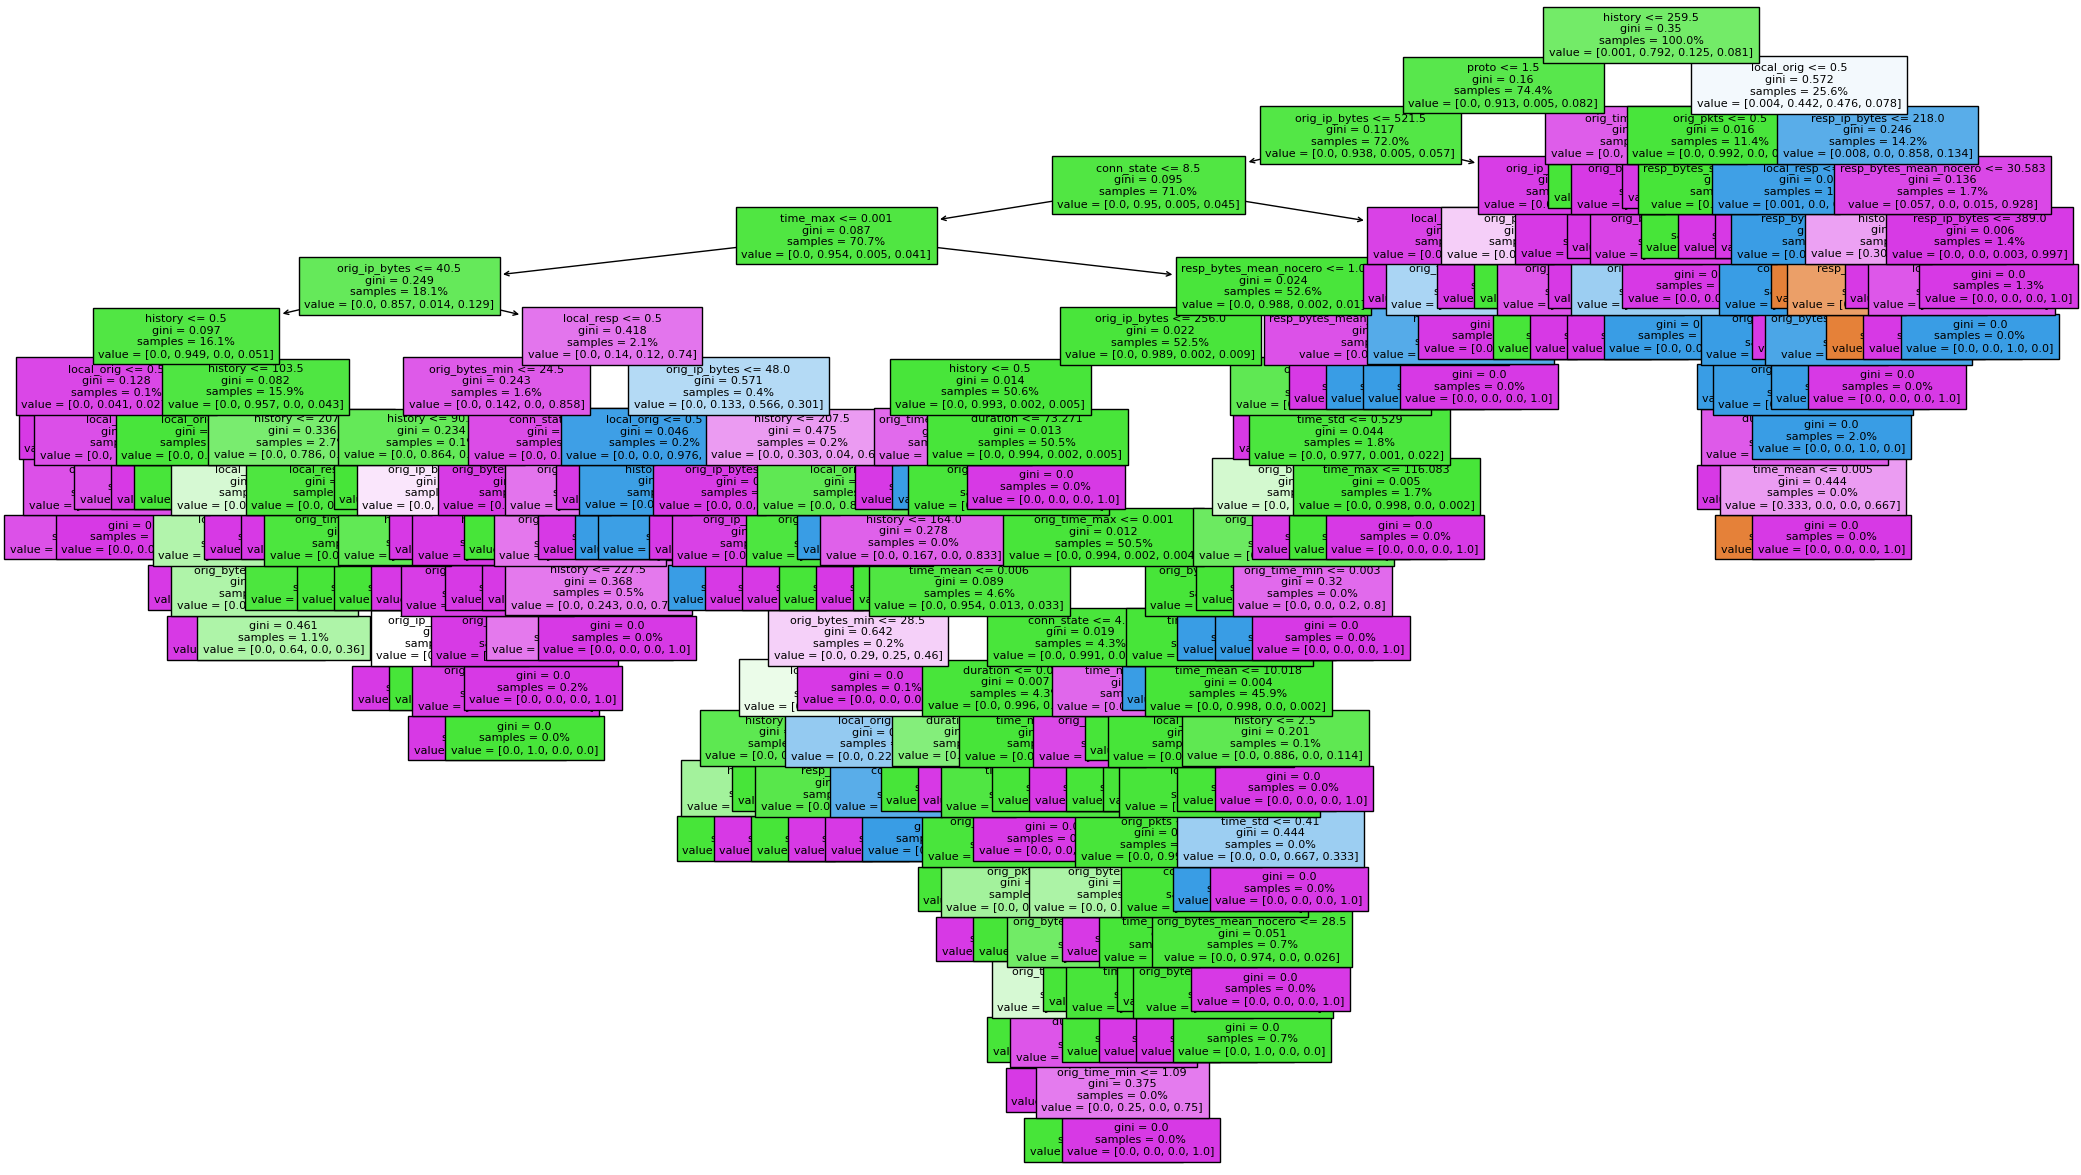

In [31]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(25, 15))  # Adjust the size as needed
# Plot the decision tree
tree.plot_tree(model, feature_names=x_iotd20.columns, filled=True, fontsize=8,proportion=True)

# Save the decision tree plot as an image file
tree_plot_path = os.path.join(output_folder, "decision_tree_default.png")
plt.savefig(tree_plot_path)

# Add the decision tree plot to the PDF
pdf.add_page()
pdf.chapter_title('Decision Tree')
pdf.add_image(tree_plot_path, title="Decision Tree Plot")



In [32]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred_test]))


In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred_test, average=None)
recall_scores = recall_score(y_test, y_pred_test, average=None)

print(precision_score(y_test, y_pred_test, average=None))
print(recall_score(y_test, y_pred_test, average=None))

[0.99056604 0.99341147 0.99877426 0.97998318]
[1.         0.99824319 0.99877426 0.93290633]


In [34]:
# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.99056604
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.99341147
  Recall: 0.99824319
Class 'Scan':
  Precision: 0.99877426
  Recall: 0.99877426
Class 'benign':
  Precision: 0.97998318
  Recall: 0.93290633


In [35]:
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

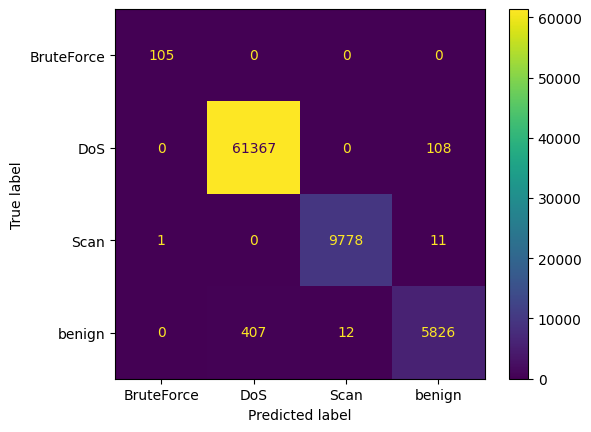

In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")


plt.show()

In [37]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer

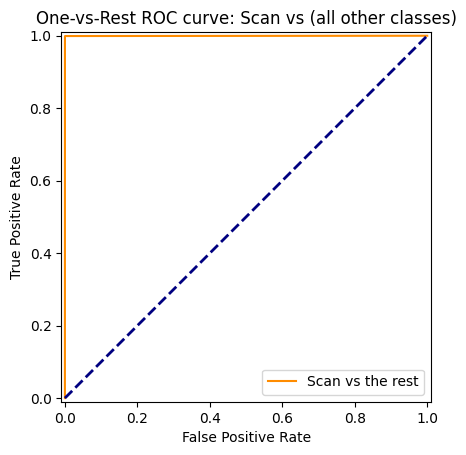

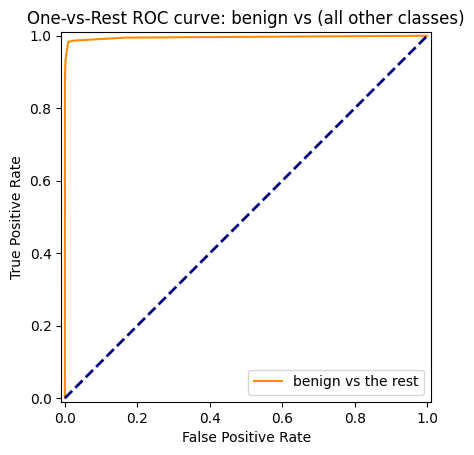

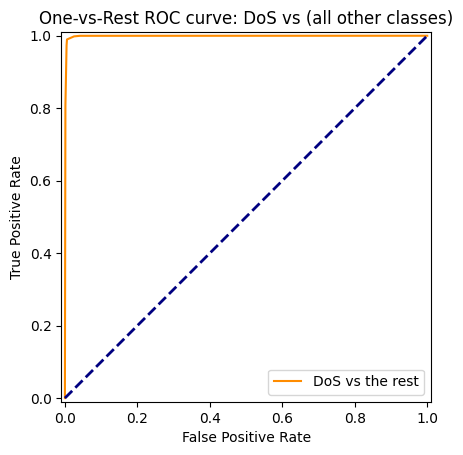

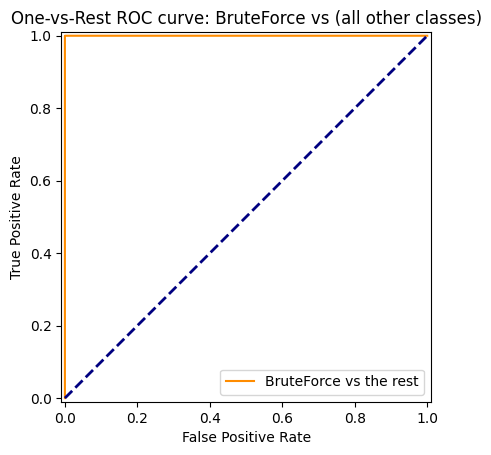

In [38]:
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

In [39]:
# Save the PDF file
pdf_path = os.path.join(pdf_folder, "default_tree_report_file.pdf")
pdf.output(pdf_path)

print("PDF report saved successfully.")

PDF report saved successfully.


## **SVM**

In [41]:
from sklearn.model_selection import GridSearchCV
model_name = "SVM_grid"


In [42]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)

# Standardize the features (important for SVM)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.transform(x_test)
x_train = x_train_scale
x_test = x_test_scale
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [ 10, 100, 1000],
    'gamma': [1e-3, 1e-4, 1e-5],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
grid_search = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

start_time = time.time()
with joblib.parallel_backend('dask'):
    grid_search.fit(x_train, y_train)
grid_search_train_time = time.time() - start_time



Fitting 5 folds for each of 27 candidates, totalling 135 fits


2024-06-17 22:37:17,748 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('batch_of__fit_and_score_1_calls-cb612ab074a040bf930cc23672674079')" coro=<Worker.execute() done, defined at /root/jupyter-env/lib/python3.9/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-06-17 22:37:17,749 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('batch_of__fit_and_score_1_calls-687fab4b315c415e926a536bf08afa74')" coro=<Worker.execute() done, defined at /root/jupyter-env/lib/python3.9/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-06-17 22:37:17,749 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('batch_of__fit_and_score_1_calls-611b910513d5476bb2dcfe75f1d3328c')" coro=<Worker.execute() done, defined at /root/jupyter-env/lib/python3.9/site-packages/distributed/worker_state_mac

2024-06-17 22:37:17,869 - distributed.scheduler - ERROR - Task batch_of__fit_and_score_1_calls-687fab4b315c415e926a536bf08afa74 marked as failed because 4 workers died while trying to run it
2024-06-17 22:37:17,950 - distributed.scheduler - ERROR - Task batch_of__fit_and_score_1_calls-075526a22f1a4e45b0a1ed627e53d5c9 marked as failed because 4 workers died while trying to run it
2024-06-17 22:37:17,952 - distributed.scheduler - ERROR - Task batch_of__fit_and_score_1_calls-d6c9f8036b3f4b279999a8d4035f77f3 marked as failed because 4 workers died while trying to run it
2024-06-17 22:37:17,963 - distributed.scheduler - ERROR - Task batch_of__fit_and_score_1_calls-fade78e0ee134fe5ae706b033e97e7b9 marked as failed because 4 workers died while trying to run it
2024-06-17 22:37:17,972 - distributed.scheduler - ERROR - Removing worker 'tcp://127.0.0.1:36053' caused the cluster to lose scattered data, which can't be recovered: {'ndarray-85a9429771174de7849d29d0f9bce1af', 'ndarray-36bb4581a77d4c8

KeyboardInterrupt: 

In [ ]:
# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

model = best_model 
print(f"Best Parameters: {best_params}")
print(f"Best Model: {best_model}")

# Measure training time for the best model
start_time = time.time()
best_model.fit(x_train, y_train)
best_model_train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = best_model.predict(x_test)
test_time = time.time() - start_time

pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')

pdf.chapter_body(f"Grid Training time: {grid_search_train_time:.4f} seconds\nBest model: {best_model} and best params: {best_params} \nTraining time: {best_model_train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/grid-svm"


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {best_model_train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)

Best Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best Model: SVC(C=1000, gamma=0.001, probability=True)
Training Time: 11.7559 seconds
Testing Time: 2.3928 seconds
Accuracy: 0.9984

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.94      0.86      0.90       106
         DoS       1.00      1.00      1.00     35679
        Scan       1.00      1.00      1.00      9747
      benign       1.00      1.00      1.00     27320

    accuracy                           1.00     72852
   macro avg       0.98      0.96      0.97     72852
weighted avg       1.00      1.00      1.00     72852

Precision per class: [0.93814433 0.99874034 0.99610256 0.99890033]
Recall per class: [0.85849057 1.         0.99640915 0.99747438]
F1-score per class: [0.89655172 0.99936977 0.99625583 0.99818685]


In [ ]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.93814433
  Recall: 0.85849057
Class 'DoS':
  Precision: 0.99874034
  Recall: 1.00000000
Class 'Scan':
  Precision: 0.99610256
  Recall: 0.99640915
Class 'benign':
  Precision: 0.99890033
  Recall: 0.99747438


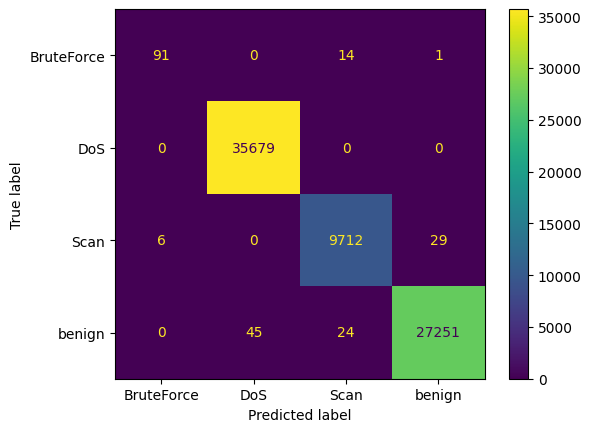

In [ ]:
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()



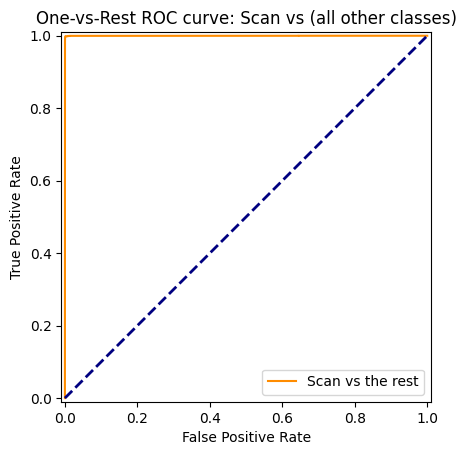

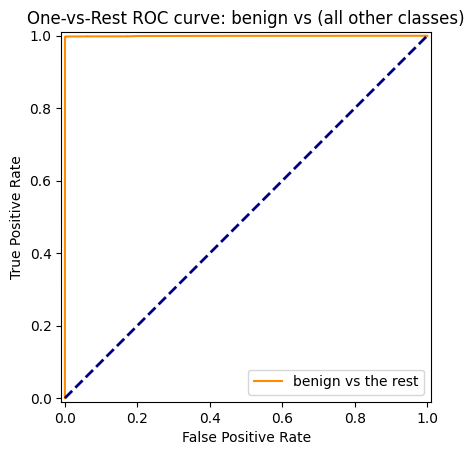

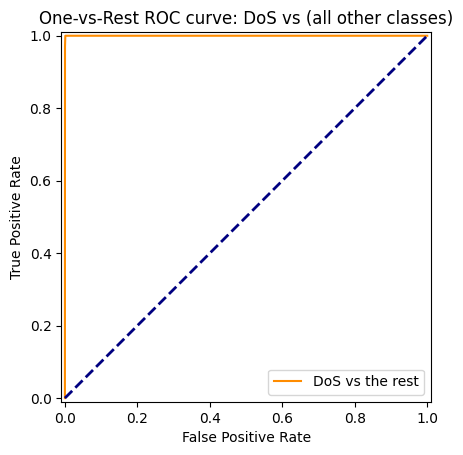

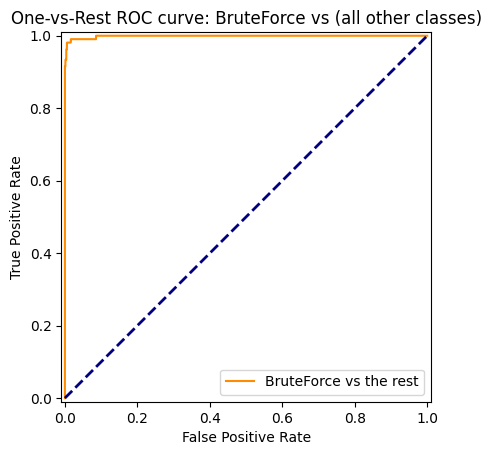

PDF report saved to /root/resultados-ml/iotd20/SVM_grid_report.pdf


In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

## **K-Nearest-Neighbors**

In [45]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time

model_name = "knn"
x_train = x_train_orig
x_test = x_test_orig

In [46]:
from sklearn.preprocessing import StandardScaler

# Standardize features for KNN
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train KNN classifier
model = KNeighborsClassifier()
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [47]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/knn"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 0.3036 seconds
Testing Time: 39.8780 seconds
Accuracy: 0.9980

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.97      0.89      0.93       106
         DoS       1.00      1.00      1.00     35679
        Scan       0.99      0.99      0.99      9747
      benign       1.00      1.00      1.00     27320

    accuracy                           1.00     72852
   macro avg       0.99      0.97      0.98     72852
weighted avg       1.00      1.00      1.00     72852

Precision per class: [0.96907216 0.99896327 0.99466557 0.99802328]
Recall per class: [0.88679245 0.99924325 0.99476762 0.99795022]
F1-score per class: [0.92610837 0.99910324 0.99471659 0.99798675]


In [48]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.96907216
  Recall: 0.88679245
Class 'DoS':
  Precision: 0.99896327
  Recall: 0.99924325
Class 'Scan':
  Precision: 0.99466557
  Recall: 0.99476762
Class 'benign':
  Precision: 0.99802328
  Recall: 0.99795022


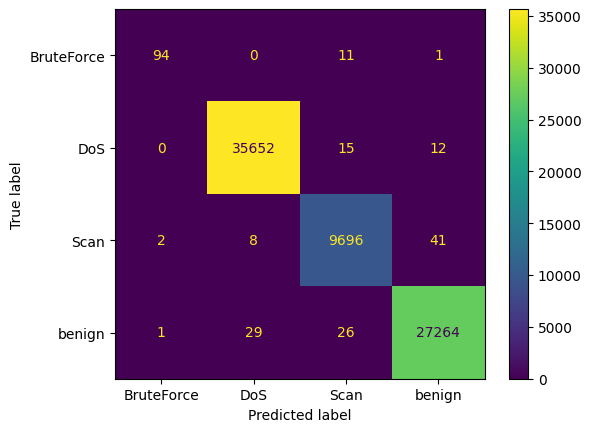

In [49]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()

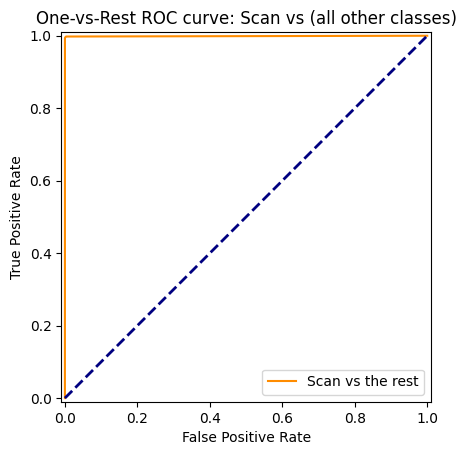

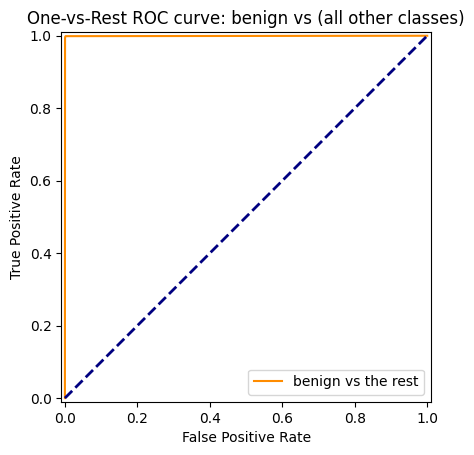

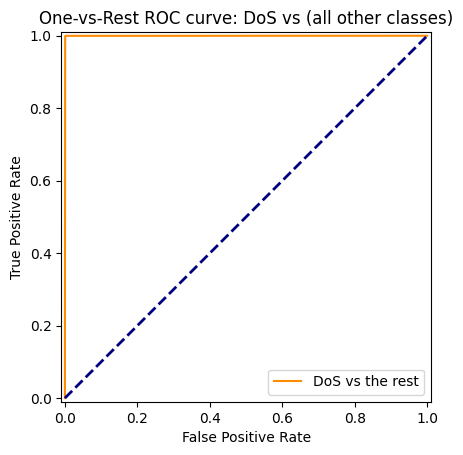

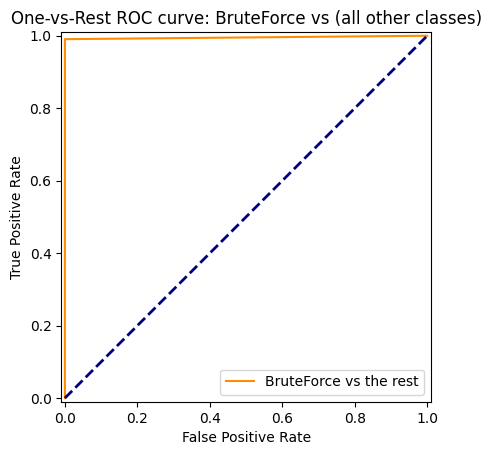

In [50]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [51]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/knn_report.pdf


## **Gaussian Naive Bayes**

In [40]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

x_train = x_train_orig
x_test = x_test_orig
model_name= "gaussian_nb"

In [41]:
# Train classifier
model = GaussianNB()
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time


In [42]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/gaussian_nb"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 


In [43]:
# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 0.3879 seconds
Testing Time: 0.4313 seconds
Accuracy: 0.3826

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.00      1.00      0.01       105
         DoS       0.72      0.48      0.57     61475
        Scan       0.30      0.00      0.00      9790
      benign       0.93      0.05      0.10      6245

    accuracy                           0.38     77615
   macro avg       0.49      0.38      0.17     77615
weighted avg       0.68      0.38      0.46     77615

Precision per class: [0.00285979 0.72176594 0.3        0.93023256]
Recall per class: [1.00000000e+00 4.76030907e-01 3.06435138e-04 5.12409928e-02]
F1-score per class: [0.00570327 0.57369143 0.00061224 0.09713158]


In [44]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.00285979
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.72176594
  Recall: 0.47603091
Class 'Scan':
  Precision: 0.30000000
  Recall: 0.00030644
Class 'benign':
  Precision: 0.93023256
  Recall: 0.05124099


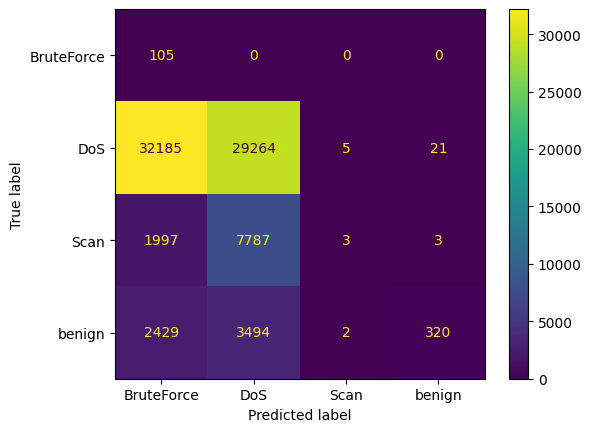

In [45]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


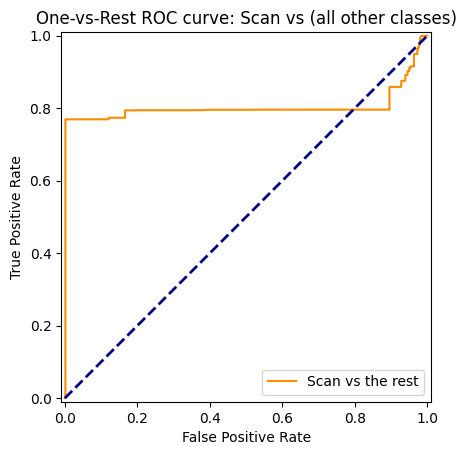

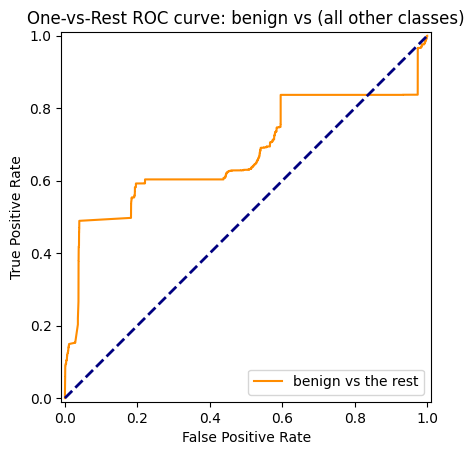

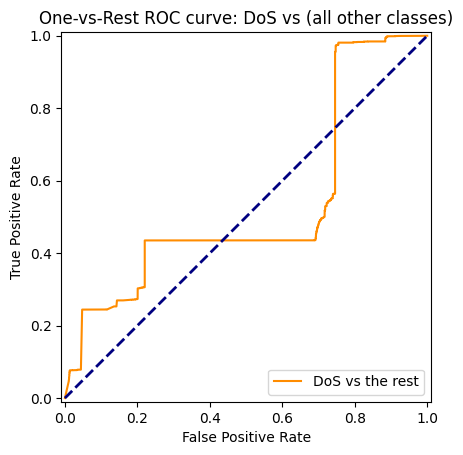

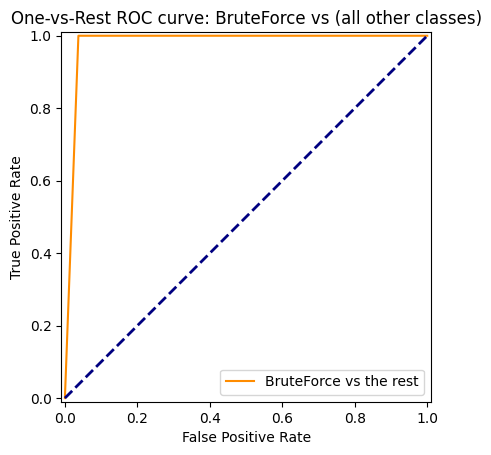

In [46]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")


In [47]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/gaussian_nb_report.pdf


## **Bernouilli Naive Bayes**

In [48]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
model_name= "bernouilli_nb"
x_train = x_train_orig
x_test = x_test_orig

In [49]:
model = BernoulliNB()
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [50]:

pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/bernouilli_nb"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 0.5336 seconds
Testing Time: 0.4138 seconds
Accuracy: 0.8283

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.08      1.00      0.15       105
         DoS       0.95      0.86      0.90     61475
        Scan       1.00      0.95      0.97      9790
      benign       0.20      0.36      0.26      6245

    accuracy                           0.83     77615
   macro avg       0.56      0.79      0.57     77615
weighted avg       0.89      0.83      0.86     77615

Precision per class: [0.07894737 0.94593622 0.99914172 0.2000352 ]
Recall per class: [1.         0.85555104 0.95127681 0.36397118]
F1-score per class: [0.14634146 0.8984762  0.97462195 0.2581781 ]


In [51]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")



Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.07894737
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.94593622
  Recall: 0.85555104
Class 'Scan':
  Precision: 0.99914172
  Recall: 0.95127681
Class 'benign':
  Precision: 0.20003520
  Recall: 0.36397118


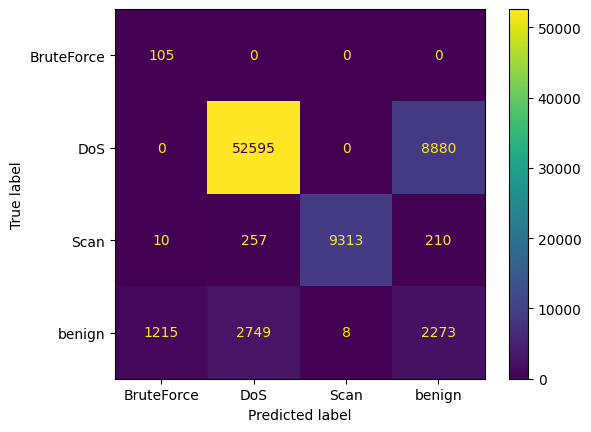

In [52]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


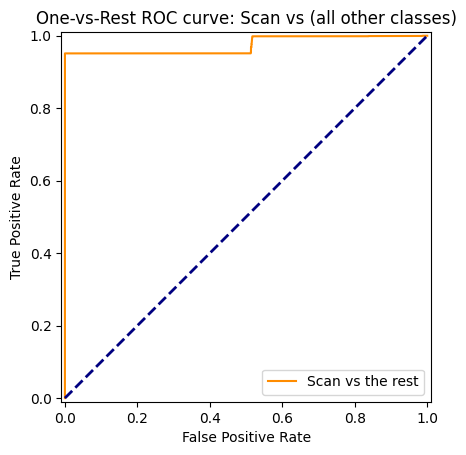

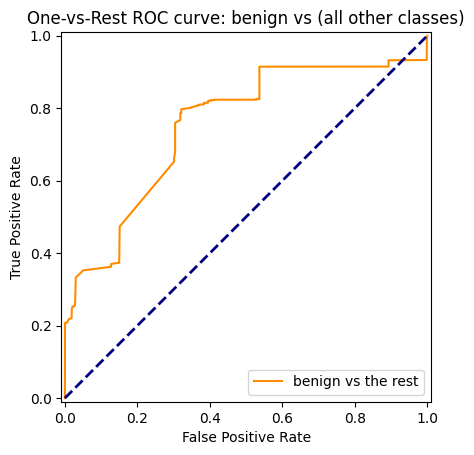

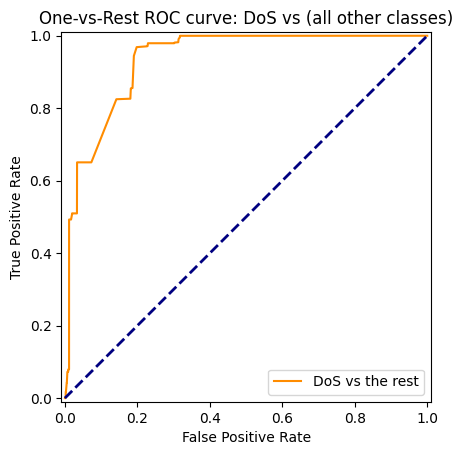

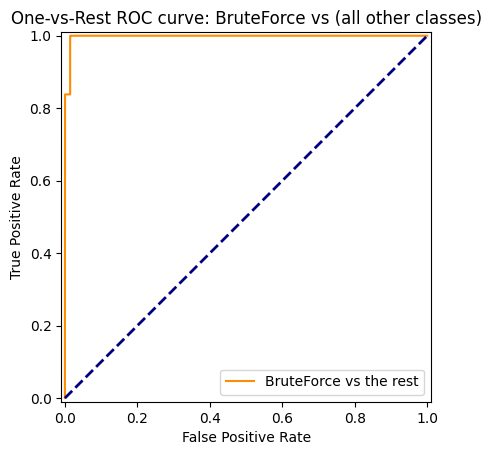

PDF report saved to /root/resultados-ml/iotd20/bernouilli_nb_report.pdf


In [53]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


## **Stochastic Gradient Descent (SGD)**

In [54]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
model_name= "sgd"
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
x_train = x_train_orig
x_test = x_test_orig

In [55]:
# Preprocessing and training for SGD
scaler = StandardScaler()
model = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3))

start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [56]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/sgd"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 2.0040 seconds
Testing Time: 0.5261 seconds
Accuracy: 0.9613

Classification Report:
              precision    recall  f1-score   support

  BruteForce       1.00      0.27      0.42       105
         DoS       0.96      1.00      0.98     61475
        Scan       0.96      0.99      0.98      9790
      benign       0.92      0.57      0.70      6245

    accuracy                           0.96     77615
   macro avg       0.96      0.71      0.77     77615
weighted avg       0.96      0.96      0.96     77615

Precision per class: [1.         0.96345009 0.96131394 0.92475918]
Recall per class: [0.26666667 0.99736478 0.99244127 0.56877502]
F1-score per class: [0.42105263 0.98011414 0.97662964 0.70434265]


In [57]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")



Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 1.00000000
  Recall: 0.26666667
Class 'DoS':
  Precision: 0.96345009
  Recall: 0.99736478
Class 'Scan':
  Precision: 0.96131394
  Recall: 0.99244127
Class 'benign':
  Precision: 0.92475918
  Recall: 0.56877502


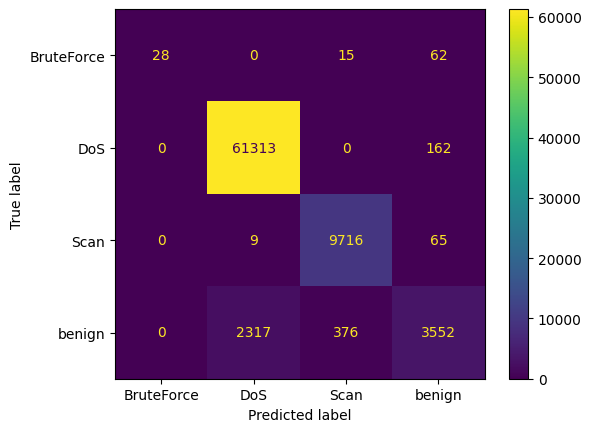

In [58]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


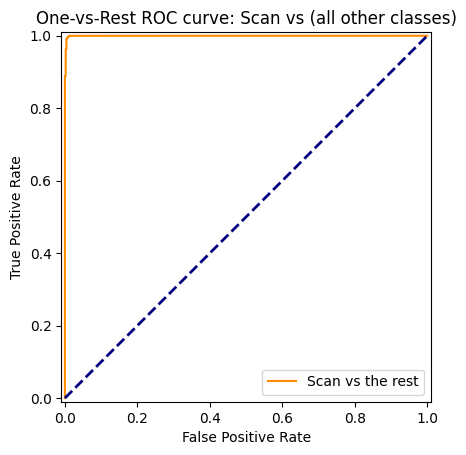

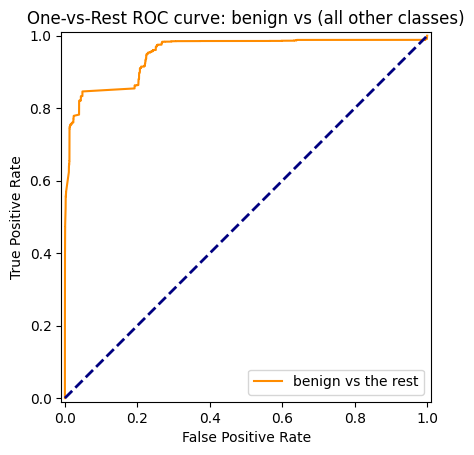

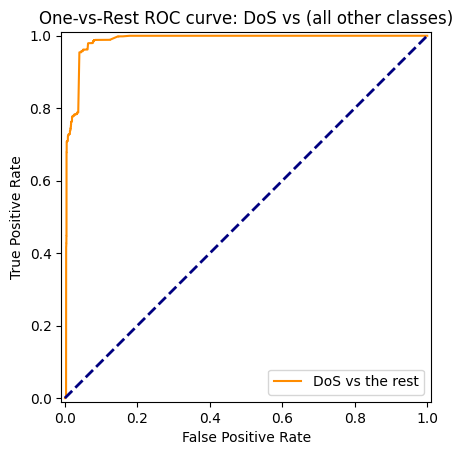

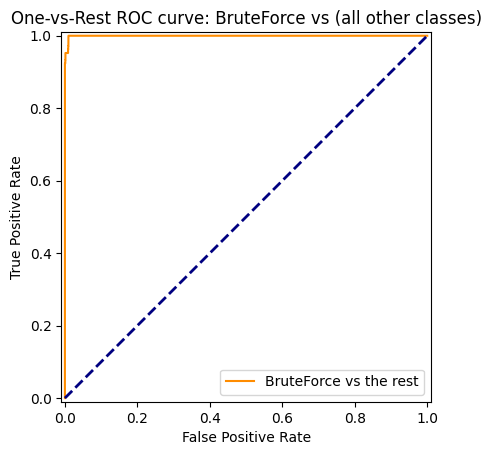

In [59]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [60]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


PDF report saved to /root/resultados-ml/iotd20/sgd_report.pdf


## **Bagging with Trees**

In [61]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
model_name= "bagging-tree"

x_train = x_train_orig
x_test = x_test_orig


In [62]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=0)
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [63]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/bagging-tree"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")


In [64]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 71.7757 seconds
Testing Time: 19.9535 seconds
Accuracy: 0.9931

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.99      1.00      1.00       105
         DoS       0.99      1.00      1.00     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.98      0.93      0.96      6245

    accuracy                           0.99     77615
   macro avg       0.99      0.98      0.99     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [0.99056604 0.99347601 0.99846829 0.98031629]
Recall per class: [1.         0.99827572 0.99877426 0.93306645]
F1-score per class: [0.99526066 0.99587008 0.99862125 0.95610797]


In [65]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.99056604
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.99347601
  Recall: 0.99827572
Class 'Scan':
  Precision: 0.99846829
  Recall: 0.99877426
Class 'benign':
  Precision: 0.98031629
  Recall: 0.93306645


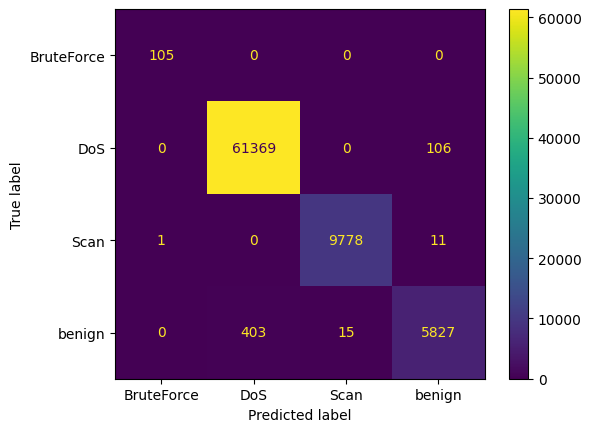

In [66]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


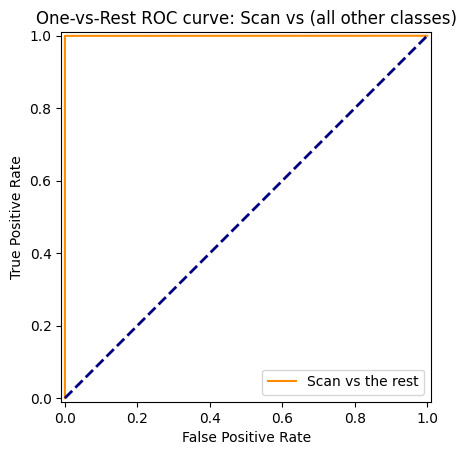

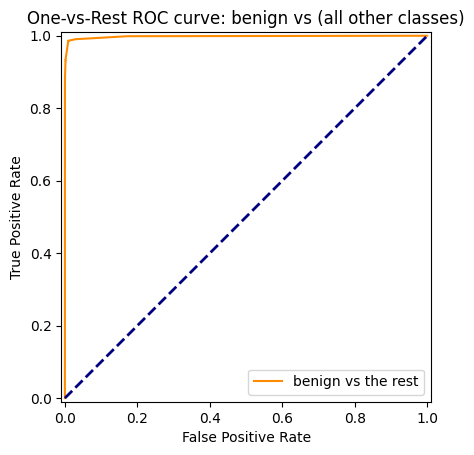

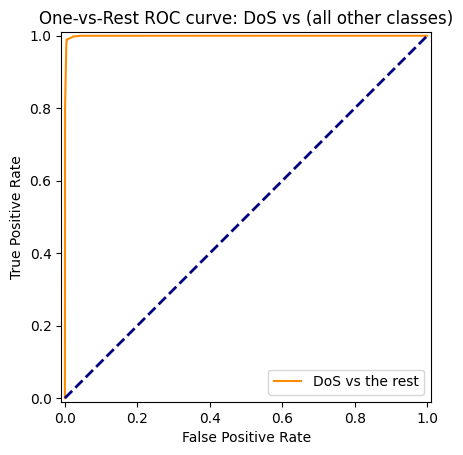

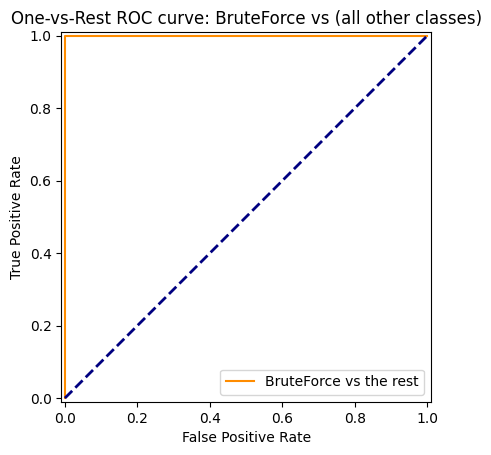

In [67]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [68]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/bagging-tree_report.pdf


## **AdaBoost**

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
model_name= "boosting-tree"
x_train = x_train_orig
x_test = x_test_orig

In [70]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=0)
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

/root/jupyter-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [71]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/boosting-tree"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 84.7112 seconds
Testing Time: 16.2671 seconds
Accuracy: 0.9929

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.98      1.00      0.99       105
         DoS       0.99      1.00      1.00     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.98      0.93      0.96      6245

    accuracy                           0.99     77615
   macro avg       0.99      0.98      0.98     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [0.98130841 0.99342776 0.99816007 0.97915966]
Recall per class: [1.         0.99827572 0.99744637 0.93290633]
F1-score per class: [0.99056604 0.99584584 0.9978031  0.95547355]


In [72]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.98130841
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.99342776
  Recall: 0.99827572
Class 'Scan':
  Precision: 0.99816007
  Recall: 0.99744637
Class 'benign':
  Precision: 0.97915966
  Recall: 0.93290633


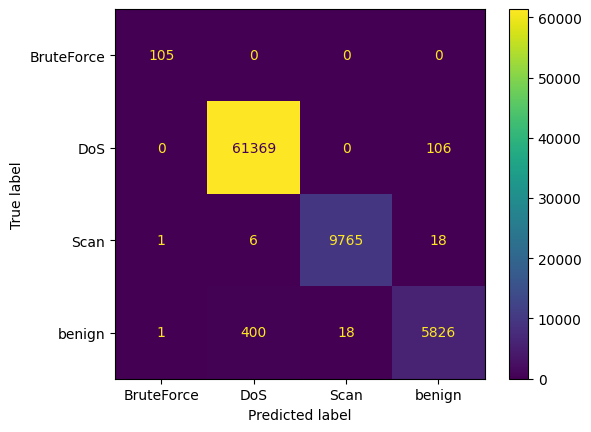

In [73]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


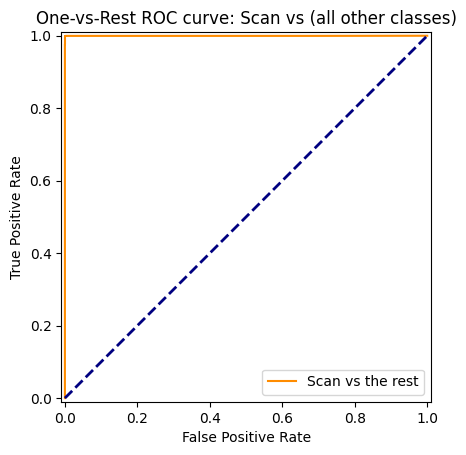

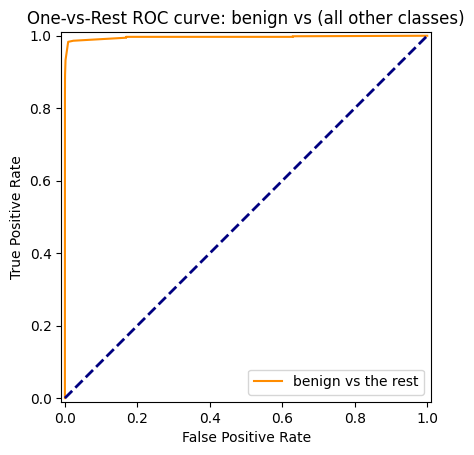

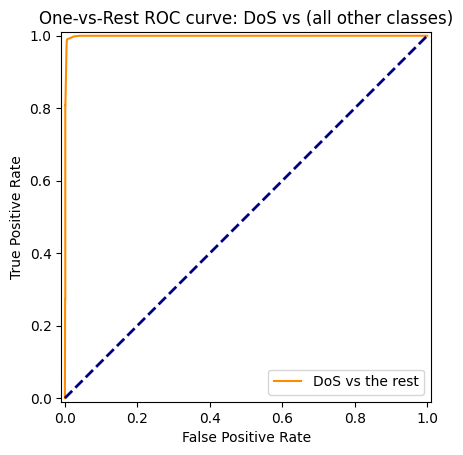

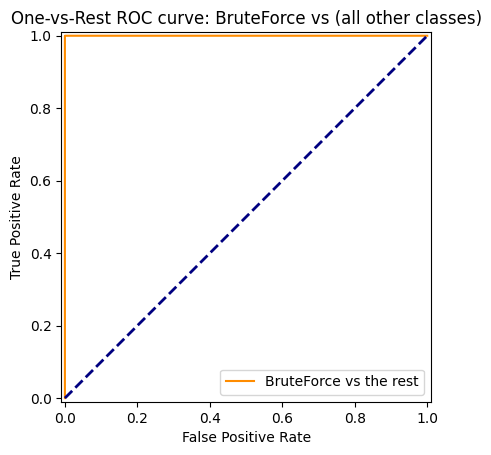

In [74]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [75]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


PDF report saved to /root/resultados-ml/iotd20/boosting-tree_report.pdf


## **Random Forest**

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
model_name= "random-forest"
x_train = x_train_orig
x_test = x_test_orig

In [77]:
# Preprocessing and training for Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [78]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/random-forest"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 8.6862 seconds
Testing Time: 0.9666 seconds
Accuracy: 0.9932

Classification Report:
              precision    recall  f1-score   support

  BruteForce       1.00      1.00      1.00       105
         DoS       0.99      1.00      1.00     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.98      0.94      0.96      6245

    accuracy                           0.99     77615
   macro avg       0.99      0.98      0.99     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [1.         0.99360469 0.99908013 0.9797048 ]
Recall per class: [1.         0.99827572 0.99846782 0.93530825]
F1-score per class: [1.         0.99593473 0.99877388 0.95699189]


In [79]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 1.00000000
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.99360469
  Recall: 0.99827572
Class 'Scan':
  Precision: 0.99908013
  Recall: 0.99846782
Class 'benign':
  Precision: 0.97970480
  Recall: 0.93530825


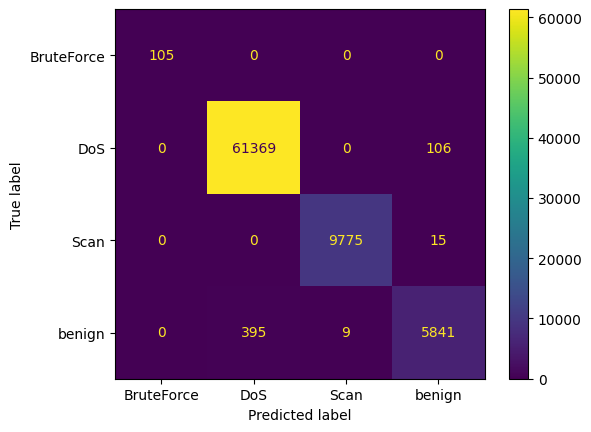

In [80]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


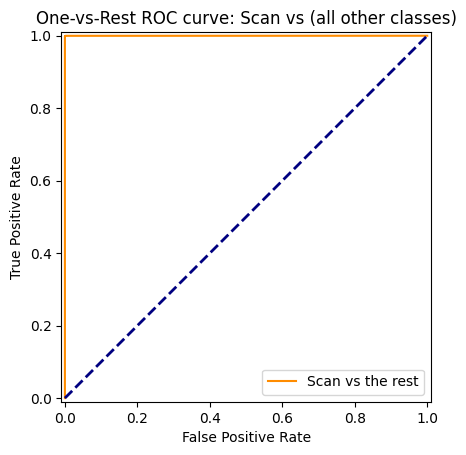

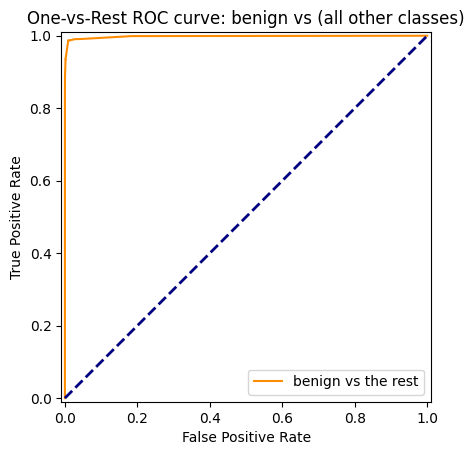

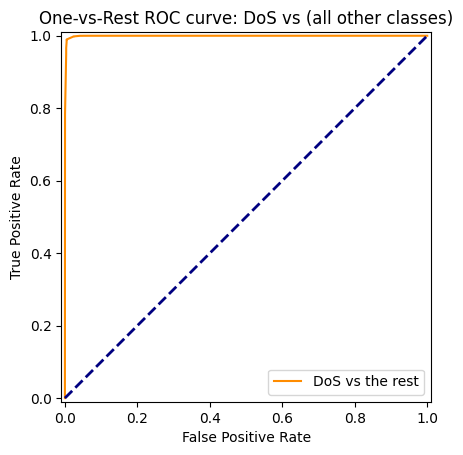

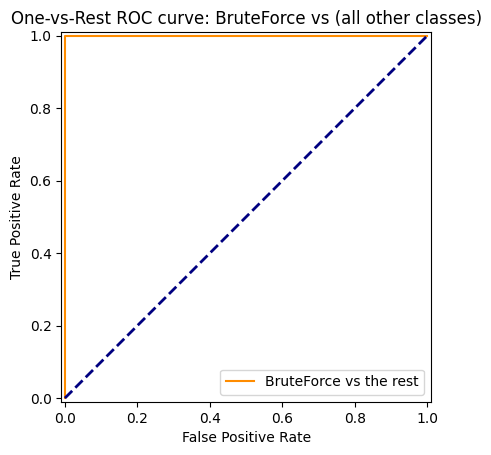

PDF report saved to /root/resultados-ml/iotd20/random-forest_report.pdf


In [81]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


## **Nearest Centroid**

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import (accuracy_score, classification_report, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay)
from fpdf import FPDF
import os
import time
import joblib
model_name= "nearest-centroid"
x_train = x_train_orig
x_test = x_test_orig

In [83]:
# Create a pipeline
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train = x_train_scaled
x_test = x_test_scaled
model = NearestCentroid()

# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time


In [84]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/nearest-centroid"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)



Training Time: 0.0811 seconds
Testing Time: 0.0367 seconds
Accuracy: 0.7919

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.03      1.00      0.06       105
         DoS       0.94      0.83      0.88     61475
        Scan       0.50      0.89      0.64      9790
      benign       0.59      0.29      0.39      6245

    accuracy                           0.79     77615
   macro avg       0.52      0.75      0.49     77615
weighted avg       0.86      0.79      0.81     77615

Precision per class: [0.0313059  0.9420647  0.50488202 0.59331386]
Recall per class: [1.         0.82711671 0.88733401 0.29271417]
F1-score per class: [0.06071119 0.88085648 0.64357683 0.3920223 ]


In [85]:

# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.03130590
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.94206470
  Recall: 0.82711671
Class 'Scan':
  Precision: 0.50488202
  Recall: 0.88733401
Class 'benign':
  Precision: 0.59331386
  Recall: 0.29271417


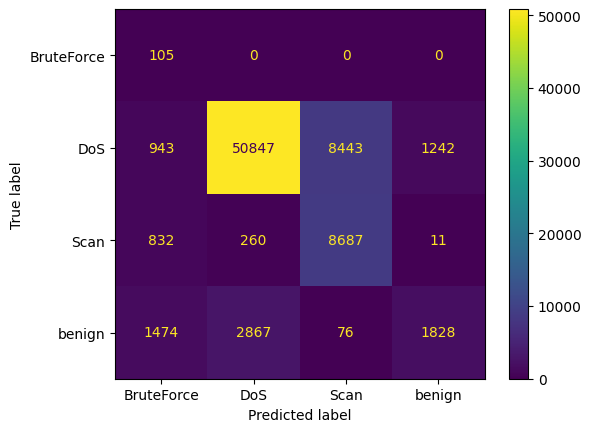

In [86]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()



<Figure size 640x480 with 0 Axes>

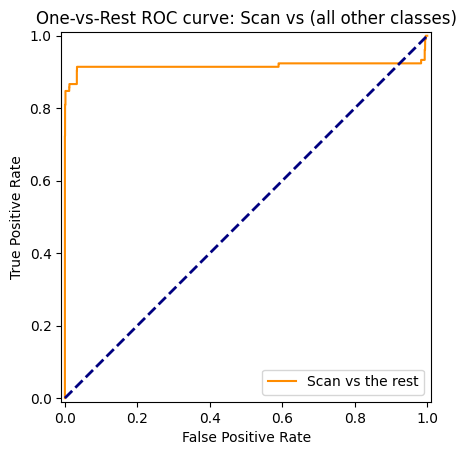

<Figure size 640x480 with 0 Axes>

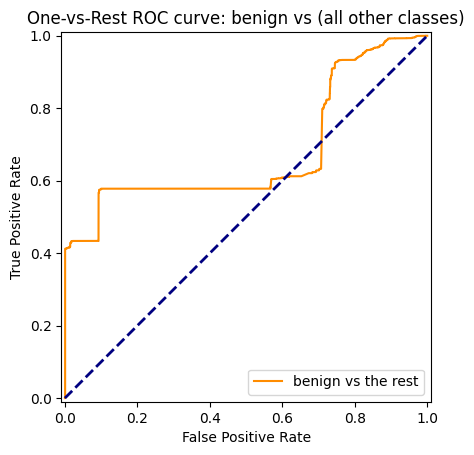

<Figure size 640x480 with 0 Axes>

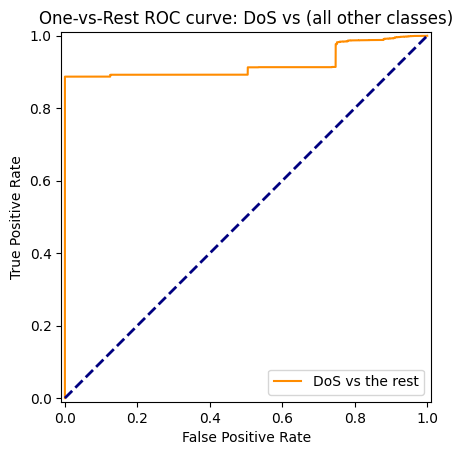

<Figure size 640x480 with 0 Axes>

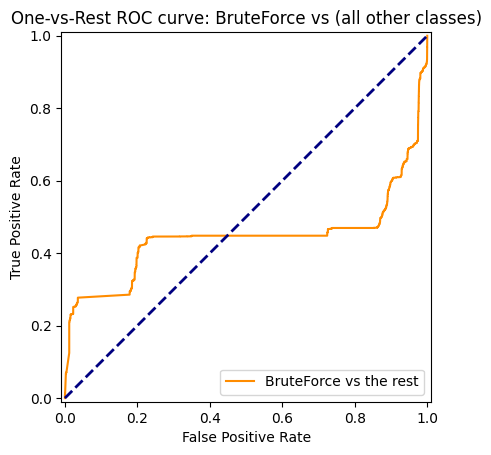

In [87]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

# ROC Curve
# Compute distances to centroids manually
centroids = model.centroids_
distances = np.linalg.norm(x_test[:, np.newaxis] - centroids, axis=2)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for i, class_of_interest in enumerate(classes_of_interest):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], -distances[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")


In [88]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/nearest-centroid_report.pdf


## **MLP**

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc,
                             ConfusionMatrixDisplay, RocCurveDisplay)
from fpdf import FPDF
import os
import time

model_name= "mlp"
x_train = x_train_orig
x_test = x_test_orig

In [90]:
# Create a pipeline
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_orig)
x_test_scaled = scaler.transform(x_test_orig)

x_train = x_train_scaled
x_test = x_test_scaled

model = MLPClassifier(max_iter=1000, random_state=42)

# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time


In [91]:
pdf_folder = "/root/resultados-ml/iotd20"
output_folder = "/root/resultados-ml/iotd20/mlp"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)



Training Time: 53.9952 seconds
Testing Time: 0.0801 seconds
Accuracy: 0.9881

Classification Report:
              precision    recall  f1-score   support

  BruteForce       1.00      0.99      1.00       105
         DoS       0.99      1.00      0.99     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.96      0.89      0.92      6245

    accuracy                           0.99     77615
   macro avg       0.99      0.97      0.98     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [1.         0.98921293 0.99755102 0.96006914]
Recall per class: [0.99047619 0.99647011 0.99856997 0.88935148]
F1-score per class: [0.99521531 0.99282826 0.99806023 0.92335827]


In [92]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 1.00000000
  Recall: 0.99047619
Class 'DoS':
  Precision: 0.98921293
  Recall: 0.99647011
Class 'Scan':
  Precision: 0.99755102
  Recall: 0.99856997
Class 'benign':
  Precision: 0.96006914
  Recall: 0.88935148


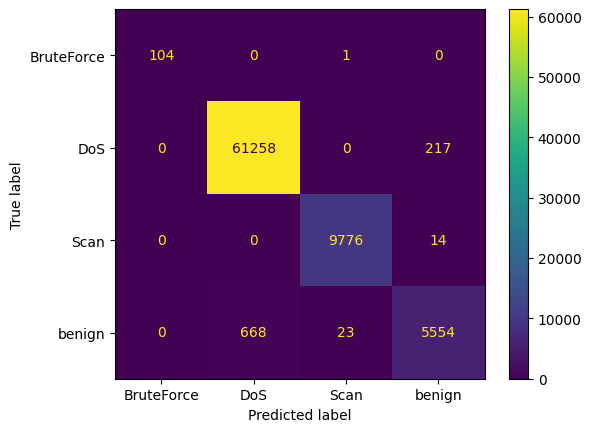

In [93]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


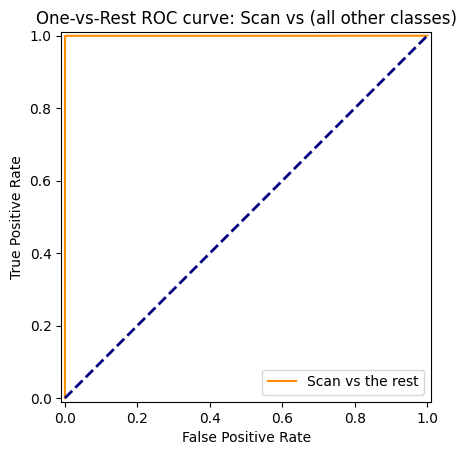

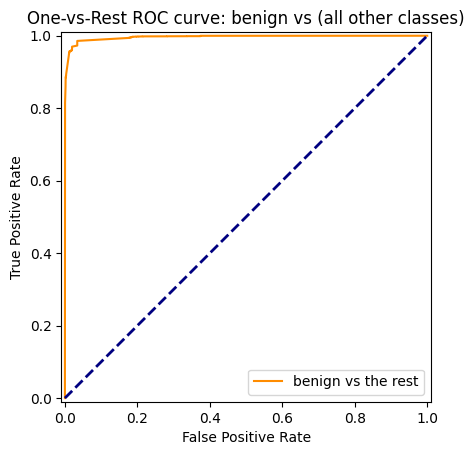

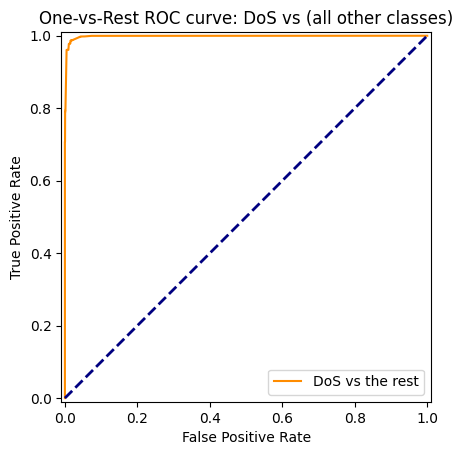

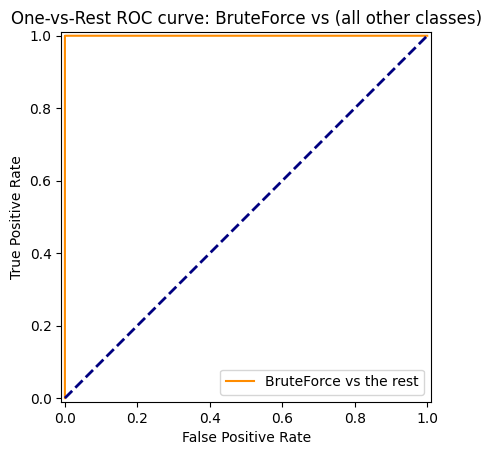

In [94]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
    
y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")


In [95]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/mlp_report.pdf


## **Selección de atributos**

In [96]:
# Reseteamos train y test
x_train, x_test, y_train, y_test = x_train_orig, x_test_orig, y_train_orig, y_test_orig

In [97]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import load_iris

# Compute the information gain for each feature
info_gain = mutual_info_classif(x_train, y_train)

# Create a DataFrame to display the information gain for each feature
feature_info_gain = pd.DataFrame({'Feature': x_iotd20.columns, 'Information Gain': info_gain})
feature_info_gain = feature_info_gain.sort_values(by='Information Gain', ascending=False)

# Display the information gain for each feature
print("Information Gain for each feature:")
print(feature_info_gain)

# Select the top k features based on information gain
k = 20  # Number of top features to select
selector = SelectKBest(mutual_info_classif, k=k)
x_train_fs = selector.fit_transform(x_train, y_train)

# Get the selected feature names
selected_features = x_iotd20.columns[selector.get_support()]

print(f"\nTop {k} features selected based on information gain:")
print(selected_features)

# Display the selected features
print("\nSelected features dataset:")
print(x_train[selected_features])

# Transform the test set using the same selector
x_test_fs = selector.transform(x_test)


Information Gain for each feature:
                   Feature  Information Gain
11           orig_ip_bytes          0.554414
9                  history          0.423647
5               conn_state          0.331233
13           resp_ip_bytes          0.312759
29               time_mean          0.282452
2                 duration          0.257918
32                time_max          0.256646
30                time_std          0.243801
36           orig_time_max          0.142830
35           orig_time_min          0.139350
33          orig_time_mean          0.135113
28          resp_pkts_cero          0.132483
6               local_orig          0.131152
12               resp_pkts          0.126205
17  orig_bytes_mean_nocero          0.114224
23          orig_bytes_max          0.112990
14         orig_bytes_mean          0.107341
3               orig_bytes          0.103761
7               local_resp          0.102019
22          resp_bytes_min          0.096491
24          resp_byt

## **Árbol de decisión con Feature selection**

In [98]:
x_train = x_train_fs
x_test = x_test_fs

In [99]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

Tiempo training

In [100]:
import time
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

Tiempo test

In [101]:
start_time = time.time()
y_pred_test = model.predict(x_test)
test_time = time.time() - start_time
# Predict probabilities
y_prob = model.predict_proba(x_test)


In [102]:
import os
output_folder = "/root/resultados-ml/iotd20/plots_tree_feat_sel"
pdf_folder = "/root/resultados-ml/iotd20/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [103]:
# Create PDF
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")


In [104]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test, y_pred_test)
pdf.add_classification_report(report)

In [105]:
y_pred_test = model.predict(x_test)
err = np.mean( y_pred_test != y_test )
acc = np.mean( y_pred_test == y_test )
print('error rate test: %f %%' % (err * 100))
print('accuracy test: %f %%' % (acc * 100))

# Add the error rate and accuracy to the PDF body
pdf.chapter_body(f"error rate test: {err * 100:.2f}%\n")
pdf.chapter_body(f"accuracy test: {acc * 100:.2f}%\n")

error rate test: 0.735683 %
accuracy test: 99.264317 %


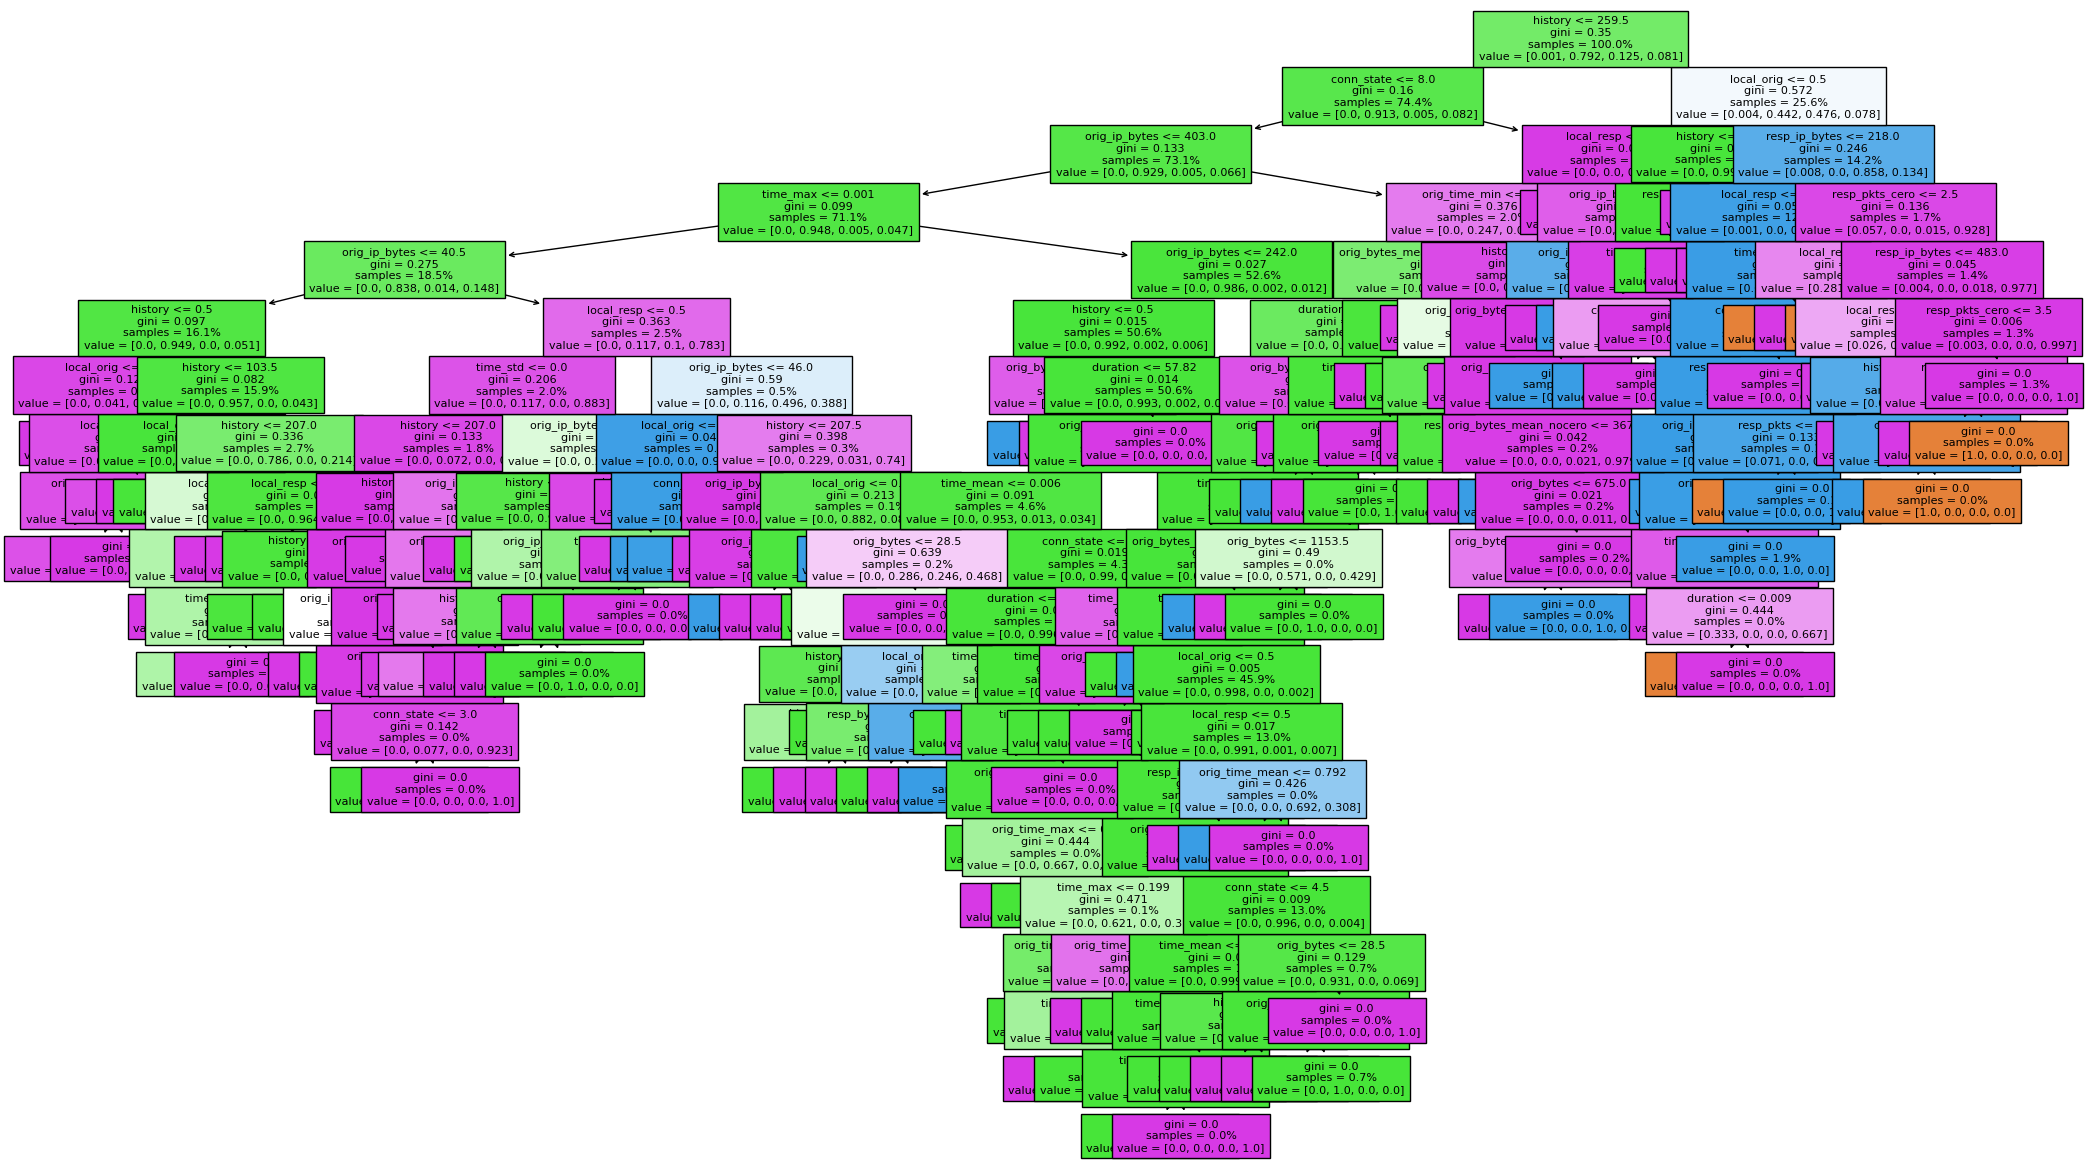

In [106]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(25, 15))  # Adjust the size as needed
# Plot the decision tree
tree.plot_tree(model, feature_names=selected_features, filled=True, fontsize=8,proportion=True)

# Save the decision tree plot as an image file
tree_plot_path = os.path.join(output_folder, "decision_tree_default.png")
plt.savefig(tree_plot_path)

# Add the decision tree plot to the PDF
pdf.add_page()
pdf.chapter_title('Decision Tree')
pdf.add_image(tree_plot_path, title="Decision Tree Plot")



In [107]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred_test]))


In [108]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(y_test, y_pred_test, average=None))
print(recall_score(y_test, y_pred_test, average=None))

[0.92857143 0.99323351 0.99867198 0.97777404]
[0.99047619 0.99808052 0.99856997 0.92986389]


In [109]:
# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 1.00000000
  Recall: 0.99047619
Class 'DoS':
  Precision: 0.98921293
  Recall: 0.99647011
Class 'Scan':
  Precision: 0.99755102
  Recall: 0.99856997
Class 'benign':
  Precision: 0.96006914
  Recall: 0.88935148


In [110]:
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

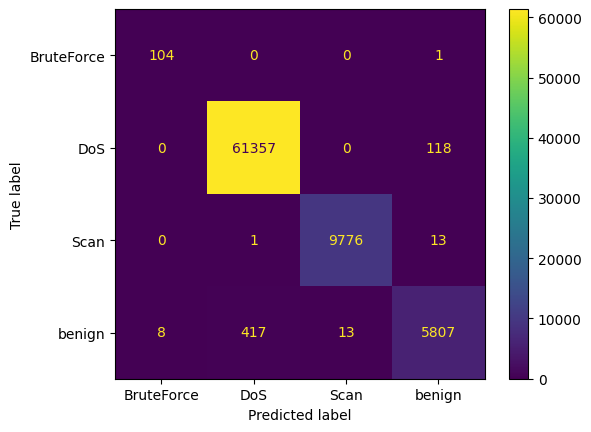

In [111]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")


plt.show()

In [112]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer

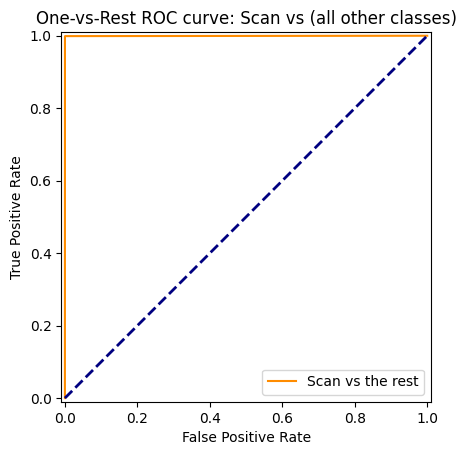

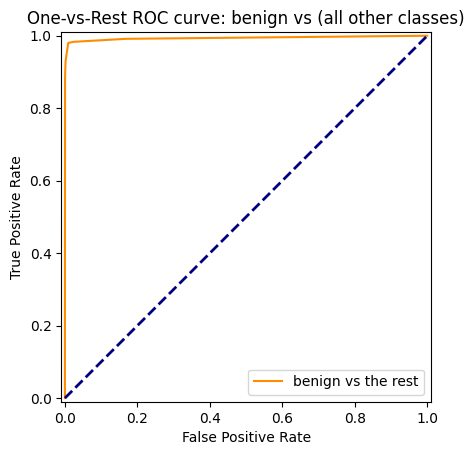

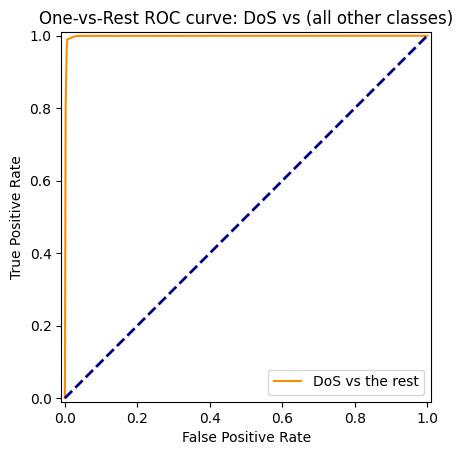

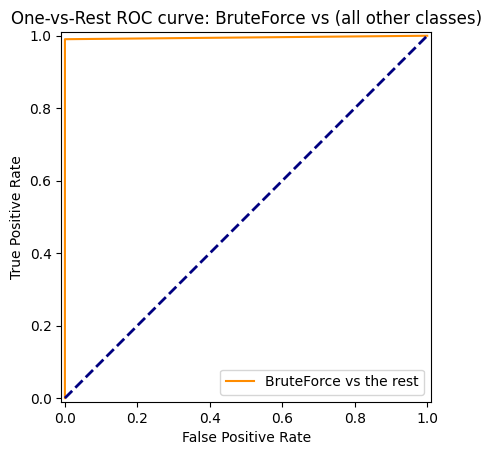

In [113]:
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

In [114]:
# Save the PDF file
pdf_path = os.path.join(pdf_folder, "feat_sel_tree_report_file.pdf")
pdf.output(pdf_path)

print("PDF report saved successfully.")

PDF report saved successfully.


## **SVM con feature selection**

In [137]:
x_train = x_train_fs
x_test = x_test_fs

In [138]:
from sklearn.model_selection import GridSearchCV
model_name = "SVM_grid_fs"
output_folder = "/root/resultados-ml/iotd20/grid-svm-fs"

In [139]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)

# Standardize the features (important for SVM)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.transform(x_test)
x_train = x_train_scale
x_test = x_test_scale
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [ 1, 100, 1000],
    'gamma': [1e-3, 1e-4, 1e-5],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
grid_search = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

start_time = time.time()
with joblib.parallel_backend('dask'):
    grid_search.fit(x_train, y_train)
grid_search_train_time = time.time() - start_time



Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [141]:
# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

model = best_model 
print(f"Best Parameters: {best_params}")
print(f"Best Model: {best_model}")

# Measure training time for the best model
start_time = time.time()
best_model.fit(x_train, y_train)
best_model_train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = best_model.predict(x_test)
test_time = time.time() - start_time

pdf.chapter_body(f"Grid Training time: {grid_search_train_time:.4f} seconds\nBest model: {best_model} and best params: {best_params} \nTraining time: {best_model_train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")
pdf_folder = "/root/resultados-ml/iotd20"


pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)

Best Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best Model: SVC(C=1000, gamma=0.001, probability=True)
Training Time: 0.3912 seconds
Testing Time: 2.0426 seconds
Accuracy: 0.9980

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.85      0.84      0.84       106
         DoS       1.00      1.00      1.00     35679
        Scan       1.00      1.00      1.00      9747
      benign       1.00      1.00      1.00     27320

    accuracy                           1.00     72852
   macro avg       0.96      0.96      0.96     72852
weighted avg       1.00      1.00      1.00     72852

Precision per class: [0.84761905 0.99874034 0.99558748 0.99835032]
Recall per class: [0.83962264 1.         0.99538319 0.99681552]
F1-score per class: [0.8436019  0.99936977 0.99548533 0.99758233]


In [142]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred_test]))

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.97115385
  Recall: 0.95283019
Class 'DoS':
  Precision: 0.99893596
  Recall: 0.99988789
Class 'Scan':
  Precision: 0.99723190
  Recall: 0.99794809
Class 'benign':
  Precision: 0.99926689
  Recall: 0.99784041


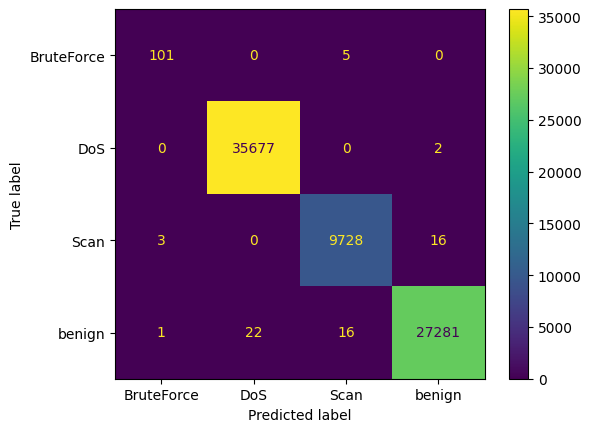

In [144]:
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()



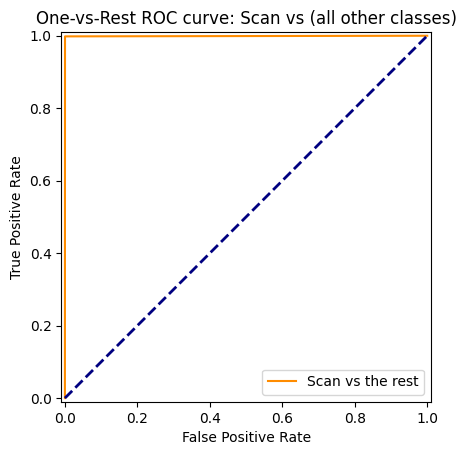

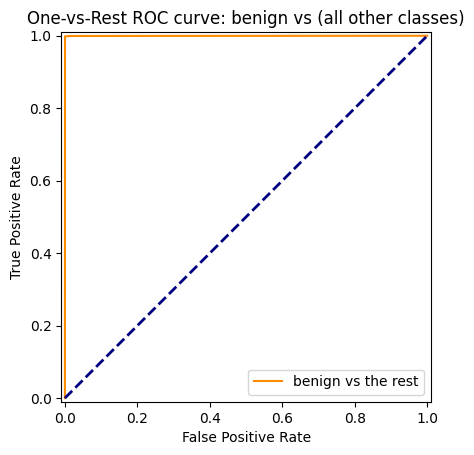

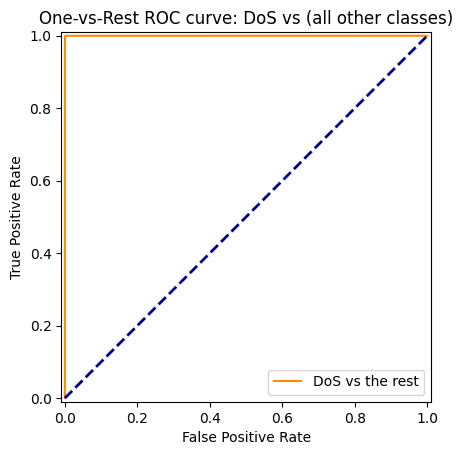

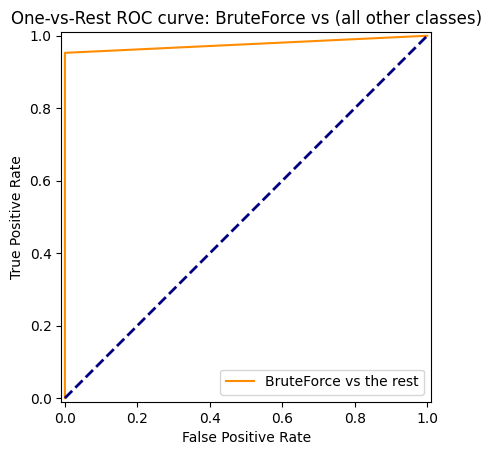

PDF report saved to /root/resultados-ml/iotd20/SVM_grid_fs_report.pdf


In [145]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

## **K-NN w/ feature selection**

In [146]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time

model_name = "knn_fs"
output_folder = "/root/resultados-ml/iotd20/knn_fs"
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
x_train = x_train_fs
x_test = x_test_fs

In [147]:
from sklearn.preprocessing import StandardScaler

# Standardize features for KNN
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train KNN classifier
model = KNeighborsClassifier()
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [148]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 0.1822 seconds
Testing Time: 33.0075 seconds
Accuracy: 0.9977

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.91      0.87      0.89       106
         DoS       1.00      1.00      1.00     35679
        Scan       0.99      0.99      0.99      9747
      benign       1.00      1.00      1.00     27320

    accuracy                           1.00     72852
   macro avg       0.98      0.96      0.97     72852
weighted avg       1.00      1.00      1.00     72852

Precision per class: [0.91089109 0.99899114 0.9937468  0.99772994]
Recall per class: [0.86792453 0.99913114 0.99456243 0.99743777]
F1-score per class: [0.88888889 0.99906114 0.99415445 0.99758383]


In [149]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.91089109
  Recall: 0.86792453
Class 'DoS':
  Precision: 0.99899114
  Recall: 0.99913114
Class 'Scan':
  Precision: 0.99374680
  Recall: 0.99456243
Class 'benign':
  Precision: 0.99772994
  Recall: 0.99743777


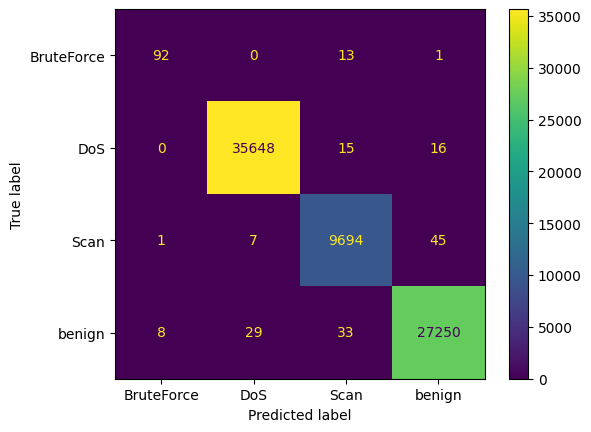

In [150]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()

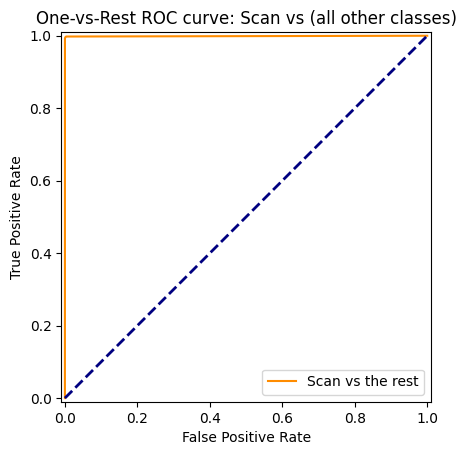

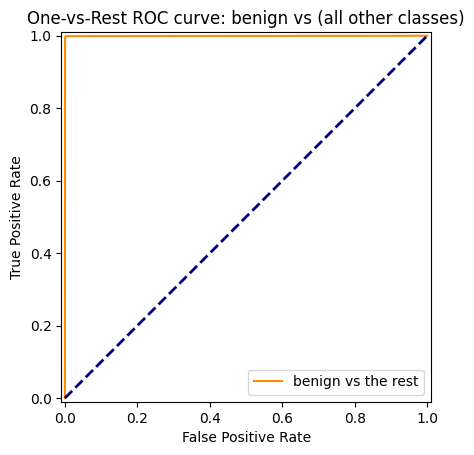

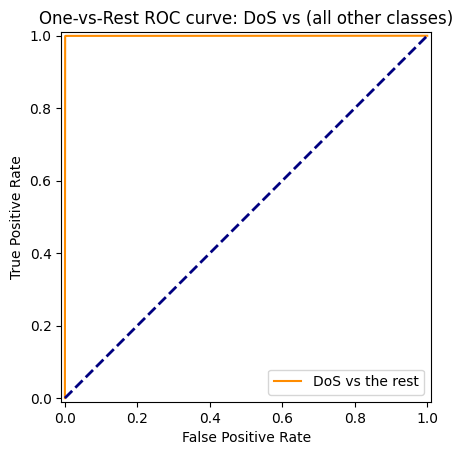

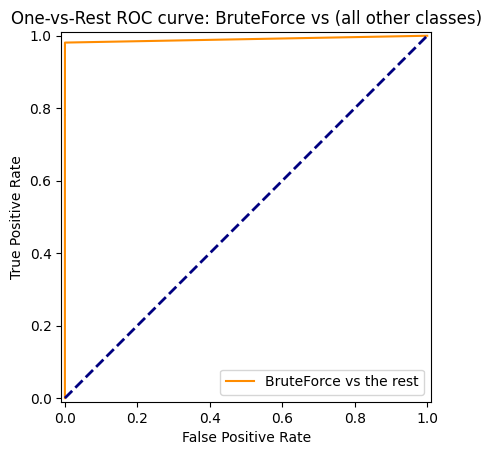

In [151]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [152]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/knn_fs_report.pdf


## **Gaussian NB w/ feature selection**

In [115]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

x_train = x_train_fs
x_test = x_test_fs
model_name= "gaussian_nb_fs"
output_folder = "/root/resultados-ml/iotd20/gaussian_nb_fs"


In [116]:
# Train classifier
model = GaussianNB()
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time


In [117]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 


In [118]:
# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 0.1908 seconds
Testing Time: 0.1289 seconds
Accuracy: 0.3483

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.00      1.00      0.01       105
         DoS       0.70      0.43      0.54     61475
        Scan       0.25      0.00      0.00      9790
      benign       0.88      0.05      0.10      6245

    accuracy                           0.35     77615
   macro avg       0.46      0.37      0.16     77615
weighted avg       0.66      0.35      0.43     77615

Precision per class: [0.00266667 0.70248283 0.25       0.87903226]
Recall per class: [1.00000000e+00 4.32631151e-01 2.04290092e-04 5.23618895e-02]
F1-score per class: [5.31914894e-03 5.35480948e-01 4.08246581e-04 9.88363307e-02]


In [119]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.00266667
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.70248283
  Recall: 0.43263115
Class 'Scan':
  Precision: 0.25000000
  Recall: 0.00020429
Class 'benign':
  Precision: 0.87903226
  Recall: 0.05236189


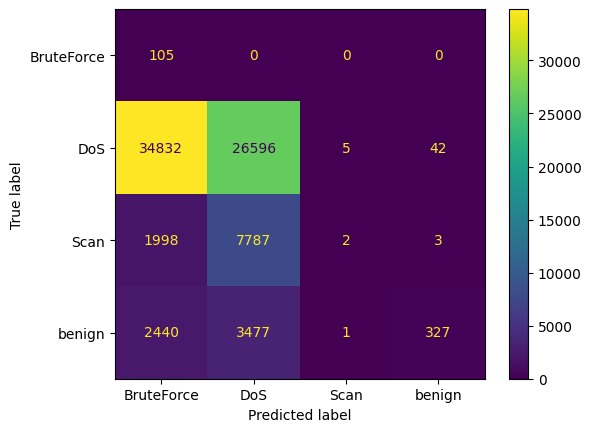

In [120]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


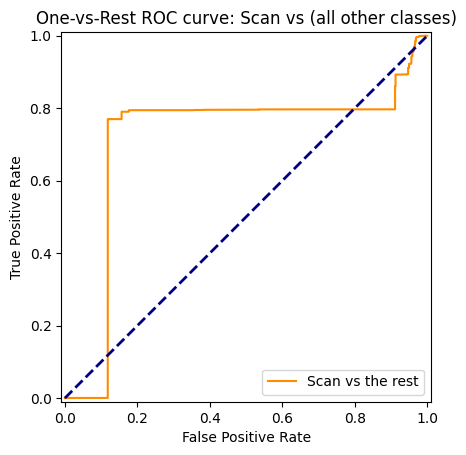

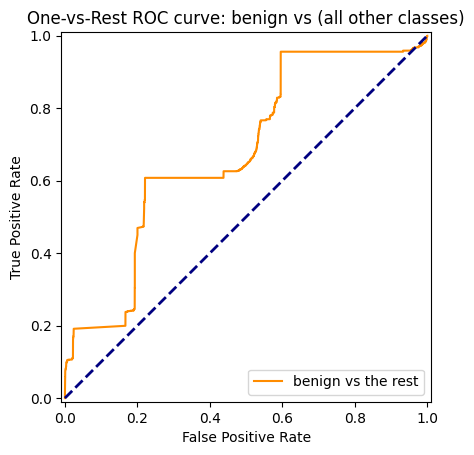

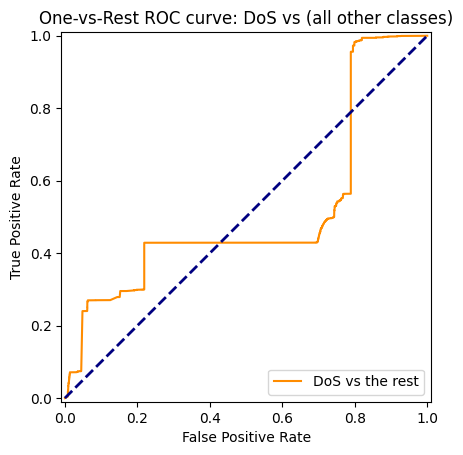

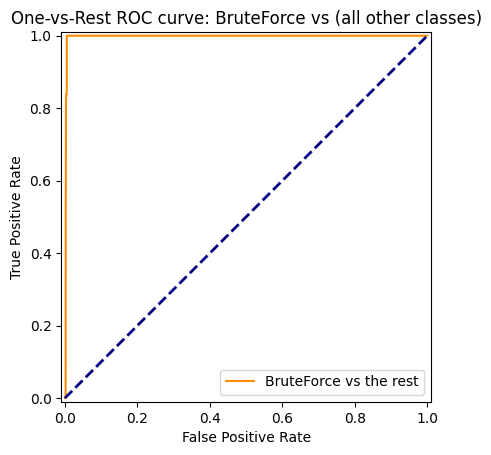

In [121]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")


In [122]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/gaussian_nb_fs_report.pdf


## **Bernouilli NB  w/ feature selection**

In [123]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
model_name= "bernouilli_nb_fs"
x_train = x_train_fs
x_test = x_test_fs
output_folder = "/root/resultados-ml/iotd20/bernouilli_nb_fs"


In [124]:
model = BernoulliNB()
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [125]:

pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 0.3411 seconds
Testing Time: 0.1125 seconds
Accuracy: 0.6971

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.06      0.84      0.12       105
         DoS       0.98      0.65      0.79     61475
        Scan       0.99      0.95      0.97      9790
      benign       0.17      0.72      0.28      6245

    accuracy                           0.70     77615
   macro avg       0.55      0.79      0.54     77615
weighted avg       0.92      0.70      0.77     77615

Precision per class: [0.06390704 0.98463913 0.98990436 0.1733564 ]
Recall per class: [0.83809524 0.65377796 0.9514811  0.72201761]
F1-score per class: [0.11875843 0.78580157 0.9703125  0.27958456]


In [126]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")



Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.06390704
  Recall: 0.83809524
Class 'DoS':
  Precision: 0.98463913
  Recall: 0.65377796
Class 'Scan':
  Precision: 0.98990436
  Recall: 0.95148110
Class 'benign':
  Precision: 0.17335640
  Recall: 0.72201761


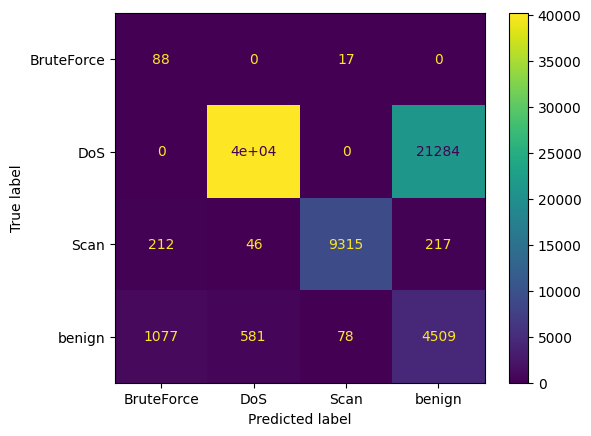

In [127]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


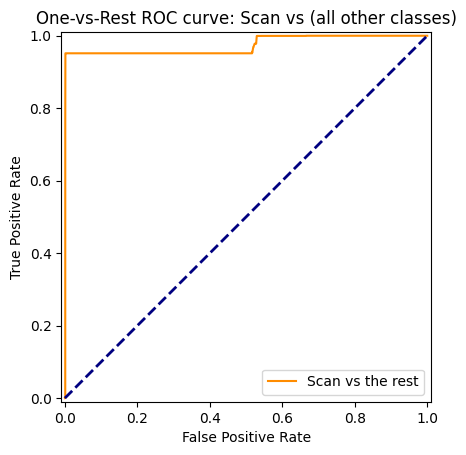

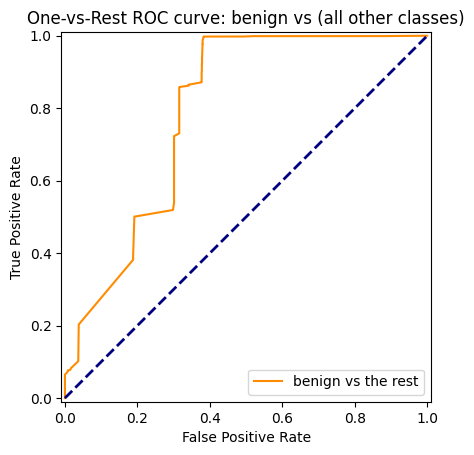

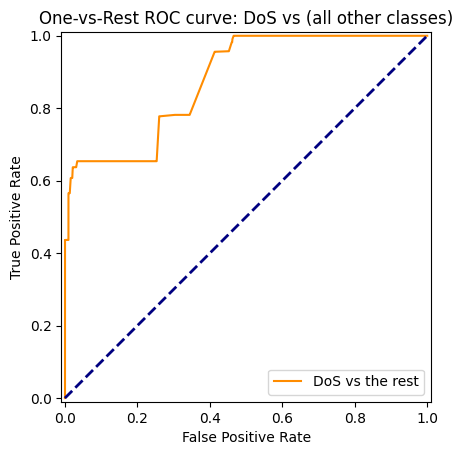

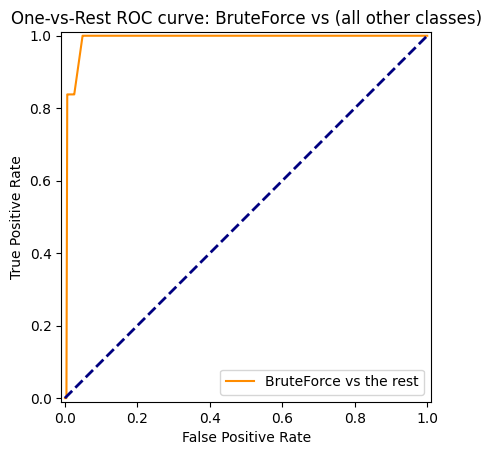

PDF report saved to /root/resultados-ml/iotd20/bernouilli_nb_fs_report.pdf


In [128]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


## **(SGD)  w/ feature selection**

In [129]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
model_name= "sgd_fs"
x_train = x_train_fs
x_test = x_test_fs
output_folder = "/root/resultados-ml/iotd20/sgd_fs"

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [130]:
# Preprocessing and training for SGD
scaler = StandardScaler()
model = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3))

start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [131]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 1.0701 seconds
Testing Time: 0.1035 seconds
Accuracy: 0.9497

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.97      0.72      0.83       105
         DoS       0.96      0.99      0.97     61475
        Scan       0.96      0.99      0.98      9790
      benign       0.81      0.50      0.61      6245

    accuracy                           0.95     77615
   macro avg       0.93      0.80      0.85     77615
weighted avg       0.95      0.95      0.94     77615

Precision per class: [0.97435897 0.95624548 0.96093519 0.80984809]
Recall per class: [0.72380952 0.98901993 0.99499489 0.49511609]
F1-score per class: [0.83060109 0.97235661 0.97766849 0.61452847]


In [132]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")



Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.97435897
  Recall: 0.72380952
Class 'DoS':
  Precision: 0.95624548
  Recall: 0.98901993
Class 'Scan':
  Precision: 0.96093519
  Recall: 0.99499489
Class 'benign':
  Precision: 0.80984809
  Recall: 0.49511609


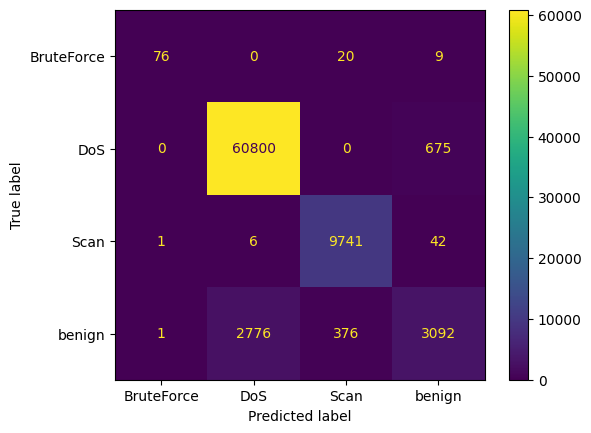

In [133]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


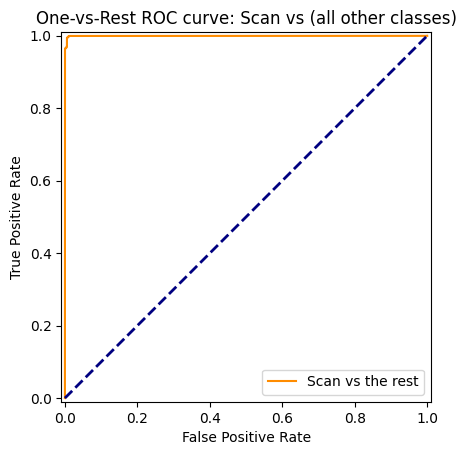

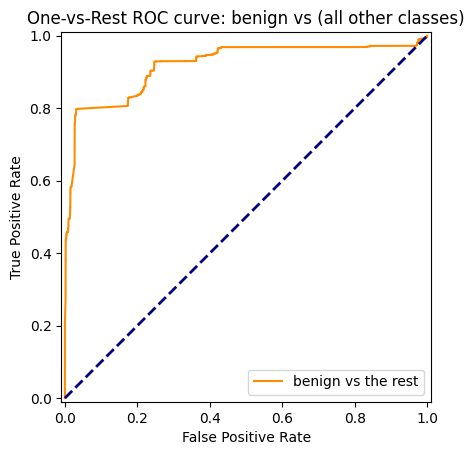

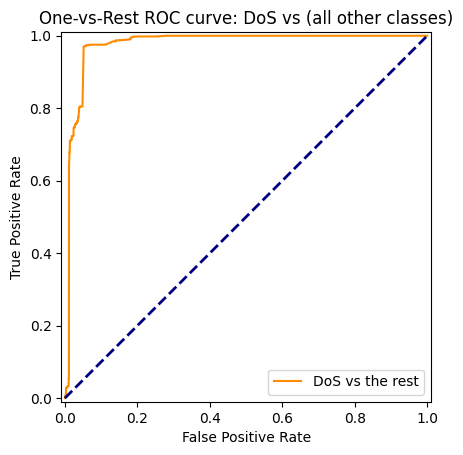

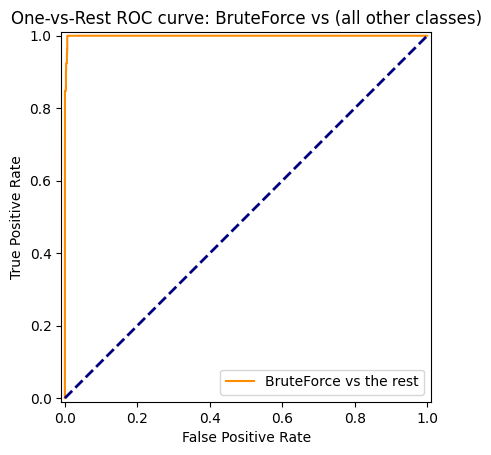

In [134]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [135]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


PDF report saved to /root/resultados-ml/iotd20/sgd_fs_report.pdf


## **Bagging w Trees  w/ feature selection**

In [136]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
model_name= "bagging-tree_fs"
x_train = x_train_fs
x_test = x_test_fs
output_folder = "/root/resultados-ml/iotd20/bagging-tree_fs"


In [137]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=0)
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [138]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")


In [139]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 50.6110 seconds
Testing Time: 9.3056 seconds
Accuracy: 0.9928

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.96      1.00      0.98       105
         DoS       0.99      1.00      1.00     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.98      0.93      0.95      6245

    accuracy                           0.99     77615
   macro avg       0.98      0.98      0.98     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [0.96330275 0.99323428 0.99887606 0.9794509 ]
Recall per class: [1.         0.99819439 0.99856997 0.93114492]
F1-score per class: [0.98130841 0.99570815 0.99872299 0.95468724]


In [140]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.96330275
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.99323428
  Recall: 0.99819439
Class 'Scan':
  Precision: 0.99887606
  Recall: 0.99856997
Class 'benign':
  Precision: 0.97945090
  Recall: 0.93114492


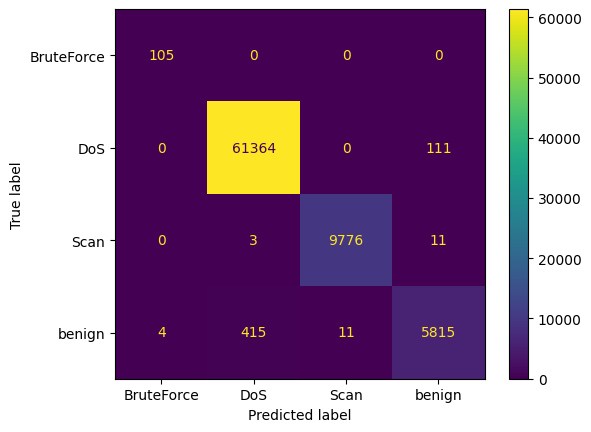

In [141]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


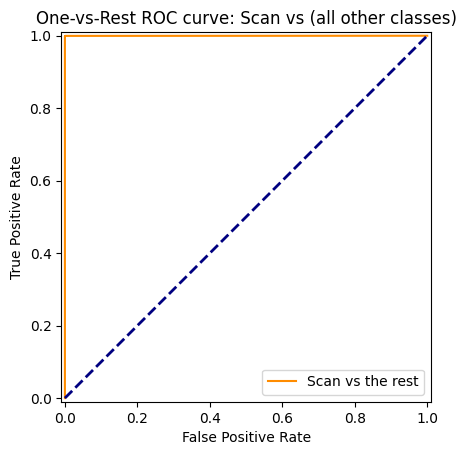

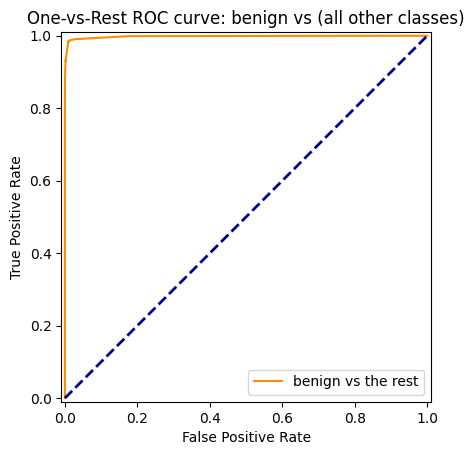

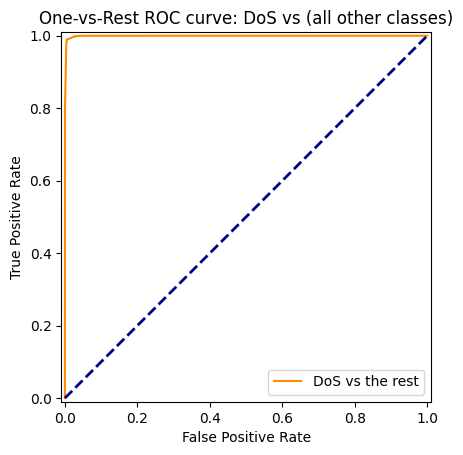

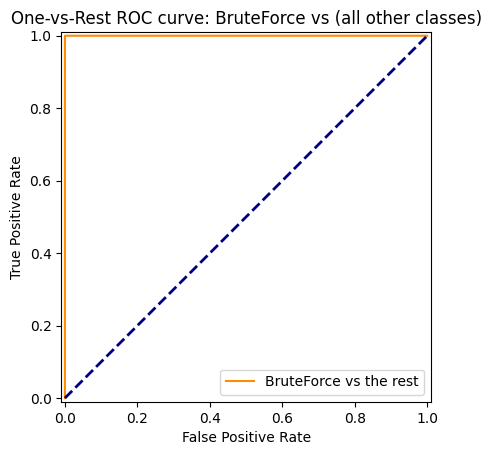

In [142]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [143]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/bagging-tree_fs_report.pdf


## **AdaBoost w Trees  w/ feature selection**

In [144]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
model_name= "boosting-tree_fs"
x_train = x_train_fs
x_test = x_test_fs
output_folder = "/root/resultados-ml/iotd20/boosting-tree_fs"


In [145]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=0)
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

/root/jupyter-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [146]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 60.5607 seconds
Testing Time: 8.0983 seconds
Accuracy: 0.9928

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.96      1.00      0.98       105
         DoS       0.99      1.00      1.00     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.98      0.93      0.95      6245

    accuracy                           0.99     77615
   macro avg       0.98      0.98      0.98     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [0.96330275 0.99347633 0.99744585 0.97913512]
Recall per class: [1.         0.99832452 0.99724208 0.93178543]
F1-score per class: [0.98130841 0.99589452 0.99734396 0.95487365]


In [147]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.96330275
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.99347633
  Recall: 0.99832452
Class 'Scan':
  Precision: 0.99744585
  Recall: 0.99724208
Class 'benign':
  Precision: 0.97913512
  Recall: 0.93178543


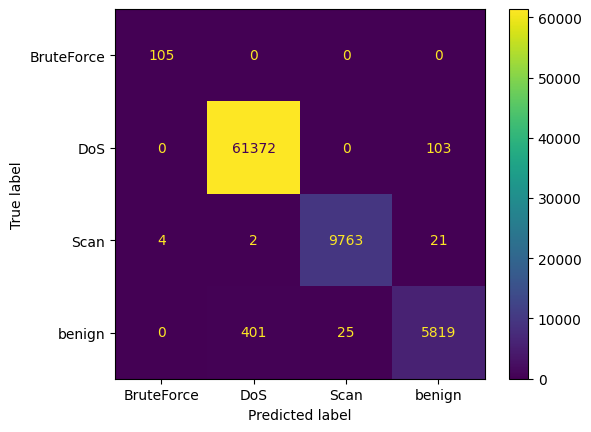

In [148]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


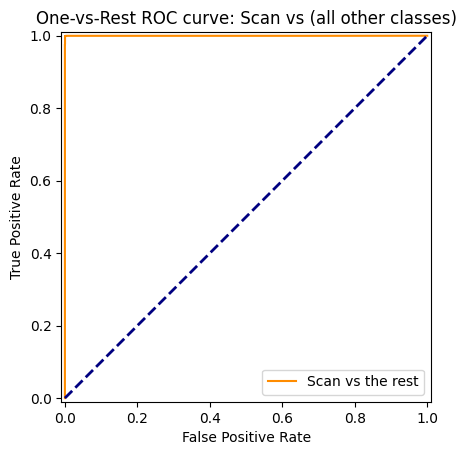

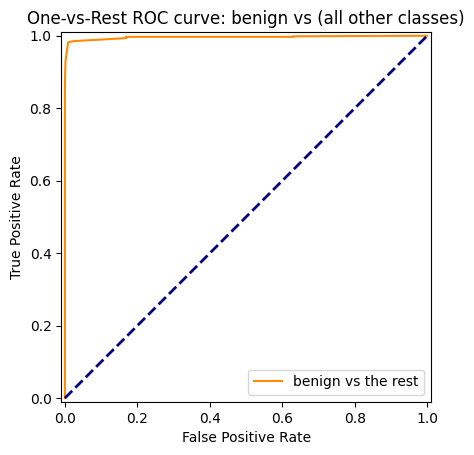

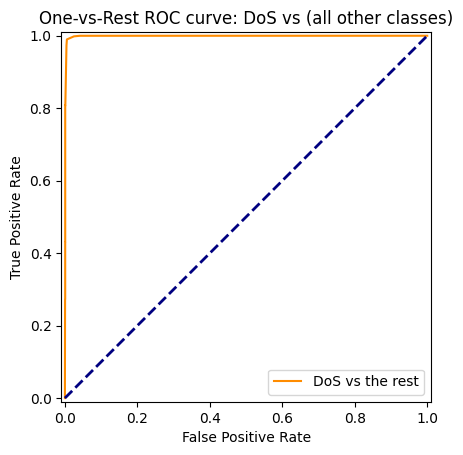

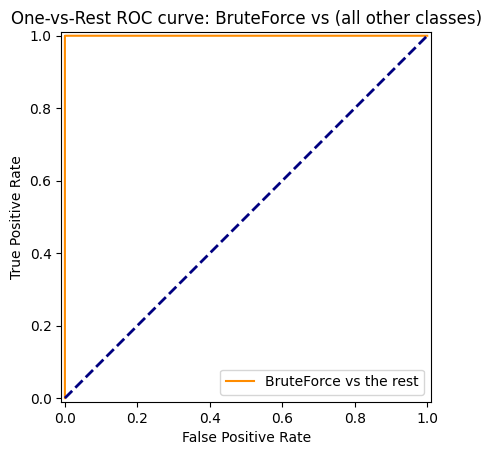

In [149]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")



In [150]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


PDF report saved to /root/resultados-ml/iotd20/boosting-tree_fs_report.pdf


## **Random Forest  w/ feature selection**

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
model_name= "random-forest_fs"
x_train = x_train_fs
x_test = x_test_fs
output_folder = "/root/resultados-ml/iotd20/random-forest_fs"



In [152]:
# Preprocessing and training for Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time

In [153]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)


Training Time: 8.0927 seconds
Testing Time: 0.6265 seconds
Accuracy: 0.9933

Classification Report:
              precision    recall  f1-score   support

  BruteForce       1.00      1.00      1.00       105
         DoS       0.99      1.00      1.00     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.98      0.93      0.96      6245

    accuracy                           0.99     77615
   macro avg       0.99      0.98      0.99     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [1.         0.99355674 0.99897865 0.98117331]
Recall per class: [1.         0.99832452 0.99908069 0.93466773]
F1-score per class: [1.         0.99593493 0.99902967 0.95735608]


In [154]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")

Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 1.00000000
  Recall: 1.00000000
Class 'DoS':
  Precision: 0.99355674
  Recall: 0.99832452
Class 'Scan':
  Precision: 0.99897865
  Recall: 0.99908069
Class 'benign':
  Precision: 0.98117331
  Recall: 0.93466773


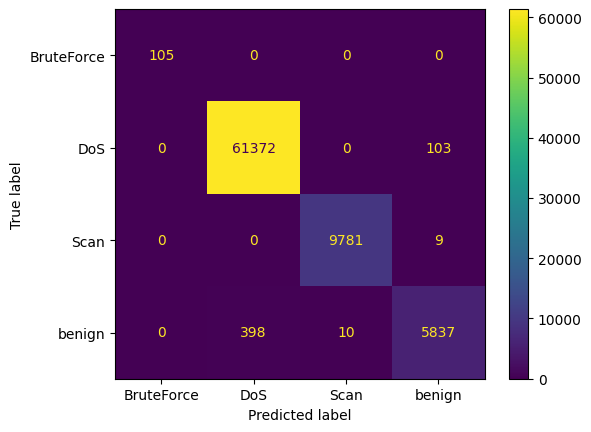

In [155]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


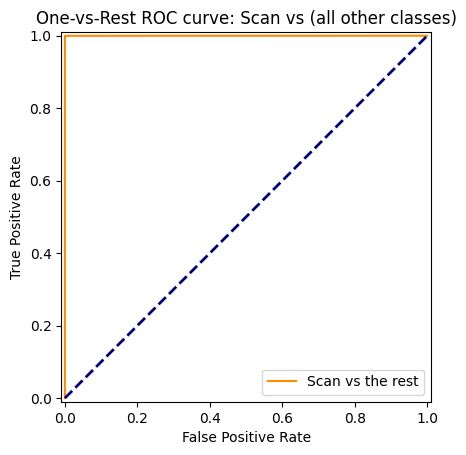

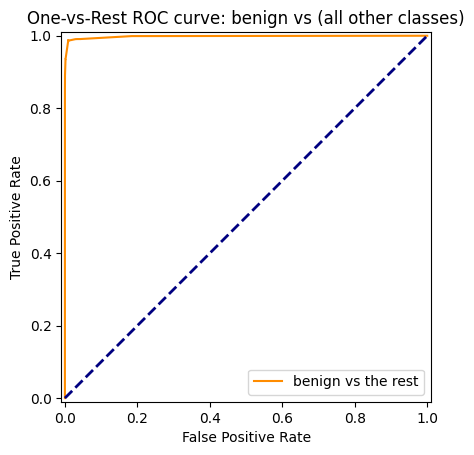

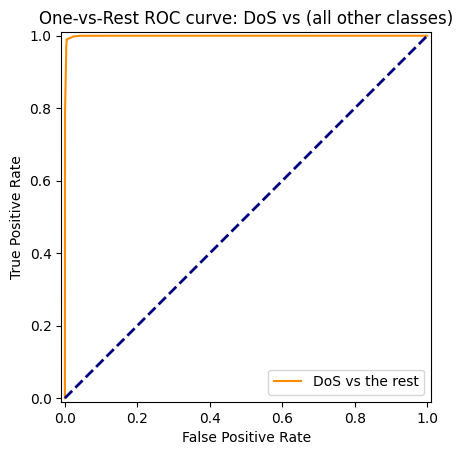

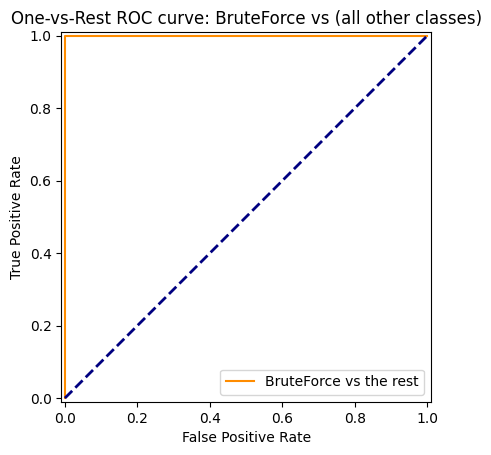

PDF report saved to /root/resultados-ml/iotd20/random-forest_fs_report.pdf


In [156]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")

# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")


## **Nearest Centroid  w/ feature selection**

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os
from fpdf import FPDF
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import (accuracy_score, classification_report, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay)
from fpdf import FPDF
import os
import time
import joblib
model_name= "nearest-centroid_fs"
x_train = x_train_fs
x_test = x_test_fs
output_folder = "/root/resultados-ml/iotd20/nearest-centroid_fs"


In [158]:
# Create a pipeline
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train = x_train_scaled
x_test = x_test_scaled
model = NearestCentroid()

# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time


In [159]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)



Training Time: 0.0723 seconds
Testing Time: 0.0340 seconds
Accuracy: 0.5278

Classification Report:
              precision    recall  f1-score   support

  BruteForce       0.09      0.93      0.17       105
         DoS       0.97      0.44      0.61     61475
        Scan       0.51      0.96      0.67      9790
      benign       0.14      0.68      0.23      6245

    accuracy                           0.53     77615
   macro avg       0.43      0.75      0.42     77615
weighted avg       0.84      0.53      0.58     77615

Precision per class: [0.09167446 0.96888225 0.51146988 0.14042156]
Recall per class: [0.93333333 0.44317202 0.96108274 0.67526021]
F1-score per class: [0.1669506  0.60816573 0.66763642 0.23249531]


In [160]:

# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 0.09167446
  Recall: 0.93333333
Class 'DoS':
  Precision: 0.96888225
  Recall: 0.44317202
Class 'Scan':
  Precision: 0.51146988
  Recall: 0.96108274
Class 'benign':
  Precision: 0.14042156
  Recall: 0.67526021


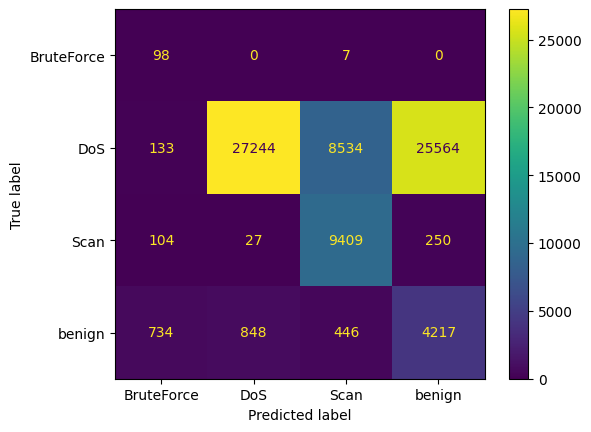

In [161]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()



<Figure size 640x480 with 0 Axes>

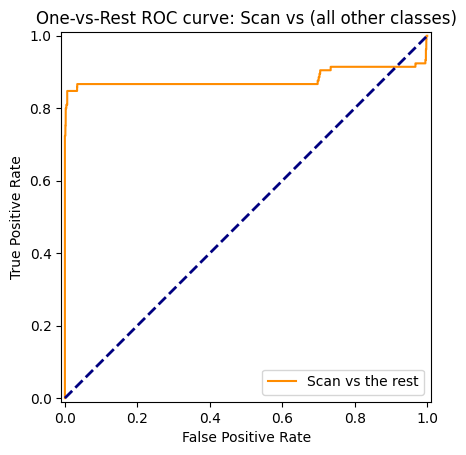

<Figure size 640x480 with 0 Axes>

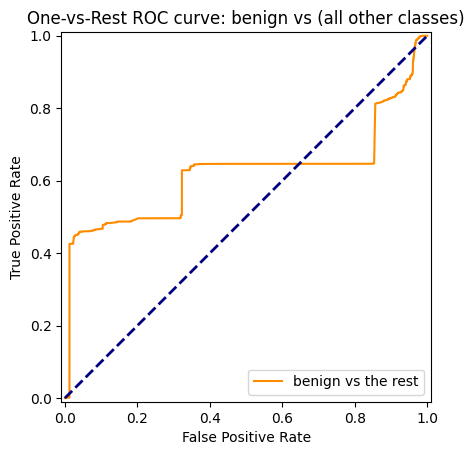

<Figure size 640x480 with 0 Axes>

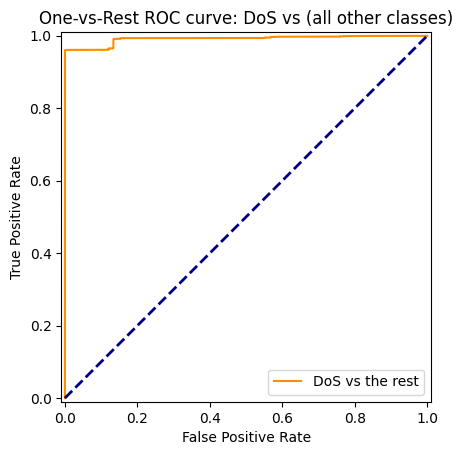

<Figure size 640x480 with 0 Axes>

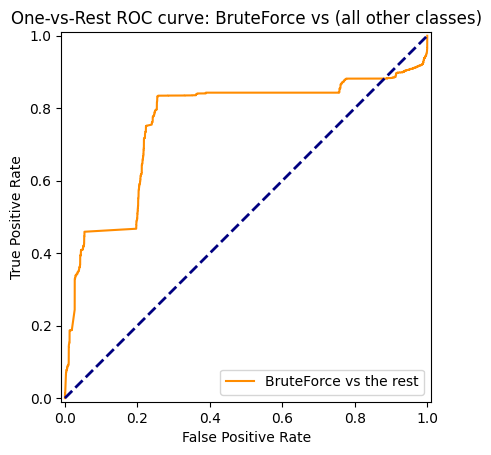

In [162]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay

# ROC Curve
# Compute distances to centroids manually
centroids = model.centroids_
distances = np.linalg.norm(x_test[:, np.newaxis] - centroids, axis=2)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for i, class_of_interest in enumerate(classes_of_interest):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], -distances[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")


In [163]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/nearest-centroid_fs_report.pdf


## **MLP  w/ feature selection**

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc,
                             ConfusionMatrixDisplay, RocCurveDisplay)
from fpdf import FPDF
import os
import time

model_name= "mlp_fs"
x_train = x_train_fs
x_test = x_test_fs
output_folder = "/root/resultados-ml/iotd20/mlp_fs"


In [165]:
# Create a pipeline
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_orig)
x_test_scaled = scaler.transform(x_test_orig)

x_train = x_train_scaled
x_test = x_test_scaled

model = MLPClassifier(max_iter=1000, random_state=42)

# Measure training time for the best model
start_time = time.time()
model.fit(x_train, y_train)
train_time = time.time() - start_time

# Measure testing time
start_time = time.time()
y_pred = model.predict(x_test)
test_time = time.time() - start_time


In [166]:
pdf_folder = "/root/resultados-ml/iotd20"
pdf = PDF()
pdf.add_page()
pdf.chapter_title('Training and Testing Time')
pdf.chapter_body(f"Training time: {train_time:.4f} seconds\nTesting time: {test_time:.4f} seconds\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

pdf.add_classification_report(report) 

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)



Training Time: 52.4406 seconds
Testing Time: 0.0842 seconds
Accuracy: 0.9881

Classification Report:
              precision    recall  f1-score   support

  BruteForce       1.00      0.99      1.00       105
         DoS       0.99      1.00      0.99     61475
        Scan       1.00      1.00      1.00      9790
      benign       0.96      0.89      0.92      6245

    accuracy                           0.99     77615
   macro avg       0.99      0.97      0.98     77615
weighted avg       0.99      0.99      0.99     77615

Precision per class: [1.         0.98921293 0.99755102 0.96006914]
Recall per class: [0.99047619 0.99647011 0.99856997 0.88935148]
F1-score per class: [0.99521531 0.99282826 0.99806023 0.92335827]


In [167]:
# Get unique classes from y_test and y_pred_test
unique_classes = np.unique(np.concatenate([y_test, y_pred]))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)

# Display precision and recall scores along with corresponding labels
print("Precision and Recall Scores by Class:")
for i, class_name in enumerate(unique_classes):
    print(f"Class '{class_name}':")
    print(f"  Precision: {precision_scores[i]:.8f}")
    print(f"  Recall: {recall_scores[i]:.8f}")
    
pdf.chapter_body("Precision and Recall Scores by Class with 8 decimals:\n")
for i, class_name in enumerate(unique_classes):
    precision = precision_scores[i]
    recall = recall_scores[i]
    pdf.chapter_body(f"Class '{class_name}':\n")
    pdf.chapter_body(f"  Precision: {precision:.8f}\n")
    pdf.chapter_body(f"  Recall: {recall:.8f}\n")


Precision and Recall Scores by Class:
Class 'BruteForce':
  Precision: 1.00000000
  Recall: 0.99047619
Class 'DoS':
  Precision: 0.98921293
  Recall: 0.99647011
Class 'Scan':
  Precision: 0.99755102
  Recall: 0.99856997
Class 'benign':
  Precision: 0.96006914
  Recall: 0.88935148


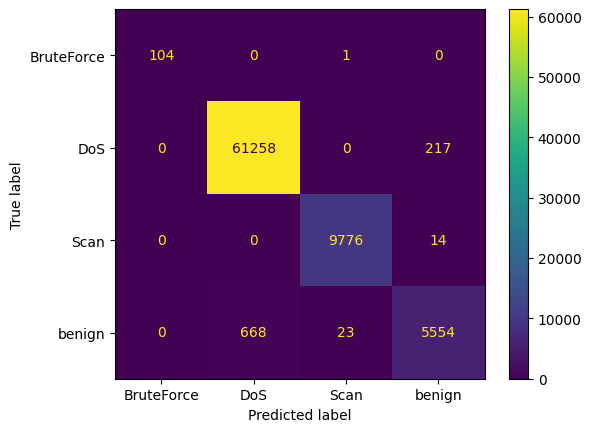

In [168]:
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score)
# Confusion matrix
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# Save the confusion matrix plot as an image file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
disp.plot()
plt.savefig(cm_plot_path)

# Add the confusion matrix plot to the PDF
pdf.add_image(cm_plot_path, title="Confusion Matrix Plot")
plt.show()


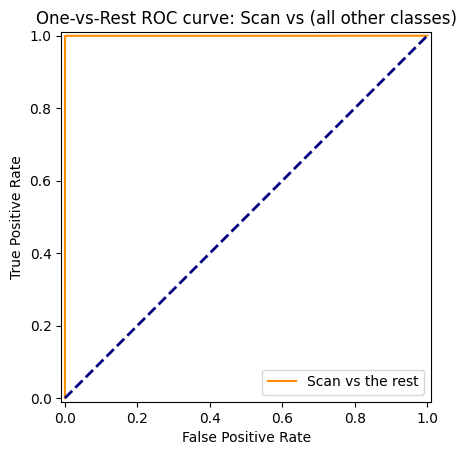

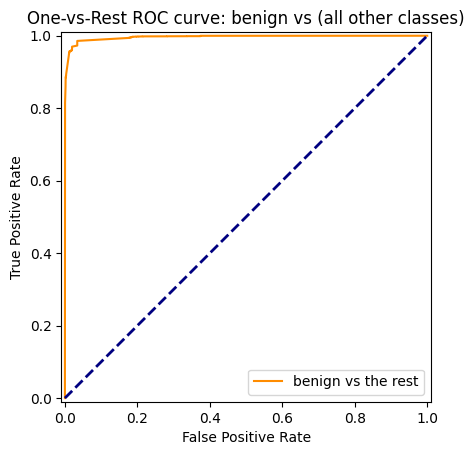

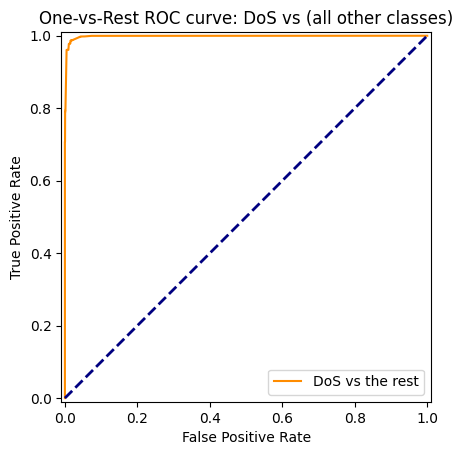

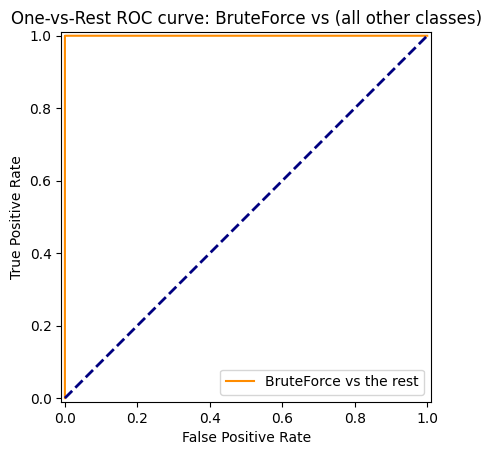

In [169]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, RocCurveDisplay
    
y_prob = model.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Define the classes of interest
classes_of_interest = ["Scan", "benign", "DoS", "BruteForce"]

# Iterate over each class
for class_of_interest in classes_of_interest:
    # Get the class index
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Compute ROC curve for the class against the rest
    fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_prob[:, class_id])

    # Plot ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{class_of_interest} vs the rest")
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC curve: {class_of_interest} vs (all other classes)")
    plt.legend(loc="lower right")

    # Save the plot as a PNG file
    plot_file = os.path.join(output_folder, f"roc_plot_{class_of_interest}.png")
    plt.savefig(plot_file)
    
    plt.show()

    # Add the ROC curve plot to the PDF
    pdf.add_image(plot_file, title=f"ROC Curve: {class_of_interest} vs (all other classes)")


In [170]:
# Save PDF
pdf_file_path = os.path.join(pdf_folder, f"{model_name}_report.pdf")
pdf.output(pdf_file_path)

print(f"PDF report saved to {pdf_file_path}")

PDF report saved to /root/resultados-ml/iotd20/mlp_fs_report.pdf
